## Intro to deep learning for medical imaging by [MD.ai](https://www.md.ai)

## Lesson 3. RSNA Pneumonia Detection Challenge (Kaggel API)

The [Radiological Society of North America](http://www.rsna.org/) Pneumonia Detection Challenge: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

This notebook covers the basics of parsing the competition dataset, training using a detector basd on the [Mask-RCNN algorithm](https://arxiv.org/abs/1703.06870) for object detection and instance segmentation.  

This notebook is developed by [MD.ai](https://www.md.ai), the platform for medical AI. 
This notebook requires Google's [TensorFlow](https://www.tensorflow.org/) machine learning framework.

**Intro to deep learning for medical imaging lessons**

- Lesson 1. Classification of chest vs. adominal X-rays using TensorFlow/Keras [Github](https://github.com/mdai/ml-lessons/blob/master/lesson1-xray-images-classification.ipynb) [Annotator](https://public.md.ai/annotator/project/PVq9raBJ)

- Lesson 2. Lung X-Rays Semantic Segmentation using UNets. [Github](https://github.com/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb)
[Annotator](https://public.md.ai/annotator/project/aGq4k6NW/workspace) 

- Lesson 3. RSNA Pneumonia detection using Kaggle data format [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace) 
  
- Lesson 3. RSNA Pneumonia detection using MD.ai python client library [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace) 

*Copyright 2018 MD.ai, Inc.   
Licensed under the Apache License, Version 2.0*

In [1]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
#-

In [2]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

### First: Install Kaggle API for download competition data.

In [3]:
# Install Kaggle API for download competition data
!pip3 install -q kaggle
#-

  Running setup.py bdist_wheel for kaggle: started
  Running setup.py bdist_wheel for kaggle: finished with status 'done'
  Stored in directory: C:\Users\ZXC\AppData\Local\pip\Cache\wheels\44\2c\df\22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify: started
  Running setup.py bdist_wheel for python-slugify: finished with status 'done'
  Stored in directory: C:\Users\ZXC\AppData\Local\pip\Cache\wheels\e3\65\da\2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


### Next: You must accept the user agreement on the competition website! Then follow [instructions to obtain your Kaggle Credentials.](https://github.com/Kaggle/kaggle-api#api-credentials)  
If you are unable to download the competition dataset, check to see if you have accepted the **user agreement** on the competition website. 

In [3]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="lixiaoqi"
os.environ['KAGGLE_KEY']="a96b56107f574e1cf4e14e3822ca2c93"

In [4]:
# Root directory of the project
ROOT_DIR = os.path.abspath('./lesson3-data')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [ ]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
!kaggle competitions download -c rsna-pneumonia-detection-challenge
#-

### Data is downloaded as zip files. Unzip the test and train datasets as well as the csv of  annotations.

In [1]:
# unzipping takes a few minutes
!unzip -q -o stage_1_test_images.zip -d stage_1_test_images
!unzip -q -o stage_1_train_images.zip -d stage_1_train_images
!unzip -q -o stage_1_train_labels.csv.zip
#-

'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


###  MD.ai Annotator 

Additionally, If you are interested in augmenting the existing annotations, you can use the MD.ai annotator to view DICOM images, and create annotatios to be exported.  
MD.ai annotator project URL for the Kaggle dataset: https://public.md.ai/annotator/project/LxR6zdR2/workspace

**Annotator features**
- The annotator can be used to view DICOM images and create image and exam level annotations.
- You can apply the annotator to filter by label, adjudicate annotations, and assign annotation tasks to your team.
- Notebooks can be built directly within the annotator for rapid model development.
- The data wrangling is abstracted away by the interface and by our MD.ai library.
- Simplifies image annotation in order to widen the participation in the futrue of medical image deep learning.

The annotator allows you to create initial annotations, build and run models, modify/finetune the annotations based on predicted values, and repeat.  
The MD.ai python client library implements functions to easily download images and annotations and to prepare the datasets used to train the model for classification. See the following example notebook for parsing annotations and training using MD.ai annotator: 
https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb  
- MD.ai URL: https://www.md.ai  
- MD.ai documentation URL: https://docs.md.ai/

### Install Matterport's Mask-RCNN model from github.
See the [Matterport's implementation of Mask-RCNN](https://github.com/matterport/Mask_RCNN).

In [7]:
os.chdir(ROOT_DIR)
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py -q install
#-

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
zip_safe flag not set; analyzing archive contents...


In [5]:
os.chdir('Mask_RCNN')
!python setup.py -q install

zip_safe flag not set; analyzing archive contents...


In [6]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [7]:
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')

### Some setup functions and classes for Mask-RCNN

- dicom_fps is a list of the dicom image path and filenames 
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [8]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [9]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    RPN_ANCHOR_SCALES = (32, 64)
    
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
    STEPS_PER_EPOCH = 100
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     

In [10]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [13]:
# training dataset
f=open(os.path.join(ROOT_DIR, 'stage_1_train_labels.csv'))
anns = pd.read_csv(f)
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [14]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [15]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array
#-

In [16]:
# show dicom fields 
ds
#-

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.5866.1517874318.703011
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '4b3dbcae-80c7-4f81-bfa9-2c3b6713cc64'
(0010, 0020) Patient ID                          LO: '4b3dbcae-80c7-4f81-bfa9-2c3b6713cc64'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

In [17]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets
**Note: We have only used only a portion of the images for demonstration purposes. See comments below.**
 
 - To use all the images do: image_fps_list = list(image_fps)
 - Or change the number of images from 100 to a custom number

In [37]:
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps)
image_fps_list = list(image_fps)#[:1000] 
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

23115 2569


### Create and prepare the training dataset using the DetectorDataset class.

In [38]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [39]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]
#-

[patientId    157a7371-119d-4549-82be-fbecaac4bf54
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 1350, dtype: object]

In [40]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

(1024, 1024, 3)
E:\学习\ml-lessons\lesson3-data\stage_1_train_images\db8433df-a208-4416-a35d-d131d8e334e3.dcm
[1]


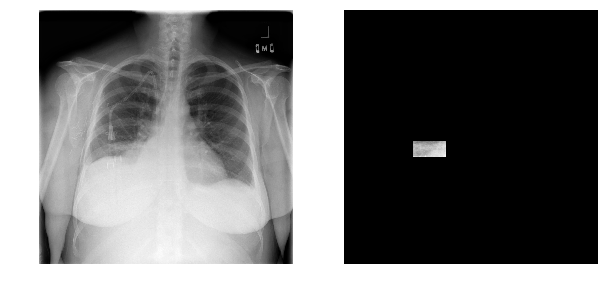

In [41]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)
#-

In [76]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

### Image Augmentation. Try finetuning some variables to custom values

In [66]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        #rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

### Now it's time to train the model. Note that training even a basic model can take a few hours. 

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time. 

- dataset_train and dataset_val are derived from DetectorDataset 
- DetectorDataset loads images from image filenames and  masks from the annotation data
- model is Mask-RCNN

In [67]:
NUM_EPOCHS = 75

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all',
            augmentation=augmentation)


Starting at epoch 0. LR=0.001

Checkpoint Path: E:\学习\ml-lessons\lesson3-data\logs\pneumonia20180927T1223\mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv

 53/100 [==============>...............] - ETA: 29:16 - loss: 7.1284 - rpn_class_loss: 1.3371 - rpn_bbox_loss: 3.4801 - mrcnn_class_loss: 0.3888 - mrcnn_bbox_loss: 1.1410 - mrcnn_mask_loss: 0.78 - ETA: 16:04 - loss: 7.1756 - rpn_class_loss: 1.2851 - rpn_bbox_loss: 3.4450 - mrcnn_class_loss: 0.4191 - mrcnn_bbox_loss: 1.2694 - mrcnn_mask_loss: 0.75 - ETA: 11:36 - loss: 6.5551 - rpn_class_loss: 1.2650 - rpn_bbox_loss: 3.0160 - mrcnn_class_loss: 0.3975 - mrcnn_bbox_loss: 1.1163 - mrcnn_mask_loss: 0.76 - ETA: 9:23 - loss: 6.1621 - rpn_class_loss: 1.2216 - rpn_bbox_loss: 2.8425 - mrcnn_class_loss: 0.3363 - mrcnn_bbox_loss: 1.0053 - mrcnn_mask_loss: 0.7565 - ETA: 8:10 - loss: 5.9057 - rpn_class_loss: 1.1817 - rpn_bbox_loss: 2.7021 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.9505 - mrcnn_mask_loss: 0.761 - ETA: 7:32 - loss: 5.6899 - rpn_class_loss: 1.1022 - rpn_bbox_loss: 2.6184 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.9120 - mrcnn_mask_loss: 0.758 - ETA: 6:43 - loss: 5.3294 - rpn_c

 53/100 [==============>...............] - ETA: 4:25 - loss: 2.6932 - rpn_class_loss: 0.1875 - rpn_bbox_loss: 0.9083 - mrcnn_class_loss: 0.2045 - mrcnn_bbox_loss: 0.7153 - mrcnn_mask_loss: 0.677 - ETA: 3:27 - loss: 2.6029 - rpn_class_loss: 0.1959 - rpn_bbox_loss: 0.9218 - mrcnn_class_loss: 0.2083 - mrcnn_bbox_loss: 0.6197 - mrcnn_mask_loss: 0.657 - ETA: 3:20 - loss: 2.5265 - rpn_class_loss: 0.2029 - rpn_bbox_loss: 0.9210 - mrcnn_class_loss: 0.1731 - mrcnn_bbox_loss: 0.5790 - mrcnn_mask_loss: 0.650 - ETA: 3:26 - loss: 2.6293 - rpn_class_loss: 0.1971 - rpn_bbox_loss: 1.0208 - mrcnn_class_loss: 0.1682 - mrcnn_bbox_loss: 0.5885 - mrcnn_mask_loss: 0.654 - ETA: 3:14 - loss: 2.6155 - rpn_class_loss: 0.2034 - rpn_bbox_loss: 1.0032 - mrcnn_class_loss: 0.1640 - mrcnn_bbox_loss: 0.5984 - mrcnn_mask_loss: 0.646 - ETA: 3:07 - loss: 2.5431 - rpn_class_loss: 0.1900 - rpn_bbox_loss: 0.9475 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.5990 - mrcnn_mask_loss: 0.640 - ETA: 2:57 - loss: 2.4841 - rpn_cl

100/100 [==============================] - ETA: 1:41 - loss: 2.4392 - rpn_class_loss: 0.1959 - rpn_bbox_loss: 0.8517 - mrcnn_class_loss: 0.2091 - mrcnn_bbox_loss: 0.5765 - mrcnn_mask_loss: 0.606 - ETA: 1:38 - loss: 2.4409 - rpn_class_loss: 0.1949 - rpn_bbox_loss: 0.8569 - mrcnn_class_loss: 0.2078 - mrcnn_bbox_loss: 0.5753 - mrcnn_mask_loss: 0.606 - ETA: 1:36 - loss: 2.4436 - rpn_class_loss: 0.1943 - rpn_bbox_loss: 0.8629 - mrcnn_class_loss: 0.2058 - mrcnn_bbox_loss: 0.5736 - mrcnn_mask_loss: 0.606 - ETA: 1:34 - loss: 2.4410 - rpn_class_loss: 0.1937 - rpn_bbox_loss: 0.8595 - mrcnn_class_loss: 0.2070 - mrcnn_bbox_loss: 0.5740 - mrcnn_mask_loss: 0.606 - ETA: 1:32 - loss: 2.4406 - rpn_class_loss: 0.1931 - rpn_bbox_loss: 0.8602 - mrcnn_class_loss: 0.2065 - mrcnn_bbox_loss: 0.5743 - mrcnn_mask_loss: 0.606 - ETA: 1:30 - loss: 2.4370 - rpn_class_loss: 0.1923 - rpn_bbox_loss: 0.8572 - mrcnn_class_loss: 0.2093 - mrcnn_bbox_loss: 0.5717 - mrcnn_mask_loss: 0.606 - ETA: 1:27 - loss: 2.4410 - rpn_cl

 53/100 [==============>...............] - ETA: 4:39 - loss: 2.3995 - rpn_class_loss: 0.2049 - rpn_bbox_loss: 0.7806 - mrcnn_class_loss: 0.2043 - mrcnn_bbox_loss: 0.6030 - mrcnn_mask_loss: 0.606 - ETA: 3:48 - loss: 2.5271 - rpn_class_loss: 0.2547 - rpn_bbox_loss: 0.7152 - mrcnn_class_loss: 0.3090 - mrcnn_bbox_loss: 0.6431 - mrcnn_mask_loss: 0.605 - ETA: 3:34 - loss: 2.3447 - rpn_class_loss: 0.2189 - rpn_bbox_loss: 0.6214 - mrcnn_class_loss: 0.2980 - mrcnn_bbox_loss: 0.6062 - mrcnn_mask_loss: 0.600 - ETA: 3:33 - loss: 2.3575 - rpn_class_loss: 0.2234 - rpn_bbox_loss: 0.6908 - mrcnn_class_loss: 0.2799 - mrcnn_bbox_loss: 0.5667 - mrcnn_mask_loss: 0.596 - ETA: 3:24 - loss: 2.2796 - rpn_class_loss: 0.1985 - rpn_bbox_loss: 0.6773 - mrcnn_class_loss: 0.2605 - mrcnn_bbox_loss: 0.5487 - mrcnn_mask_loss: 0.594 - ETA: 3:22 - loss: 2.3374 - rpn_class_loss: 0.2224 - rpn_bbox_loss: 0.6947 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.5654 - mrcnn_mask_loss: 0.595 - ETA: 3:25 - loss: 2.3017 - rpn_cl

 53/100 [==============>...............] - ETA: 3:12 - loss: 2.3598 - rpn_class_loss: 0.2245 - rpn_bbox_loss: 0.8215 - mrcnn_class_loss: 0.1581 - mrcnn_bbox_loss: 0.5439 - mrcnn_mask_loss: 0.611 - ETA: 3:35 - loss: 2.3282 - rpn_class_loss: 0.1799 - rpn_bbox_loss: 0.8521 - mrcnn_class_loss: 0.1905 - mrcnn_bbox_loss: 0.5222 - mrcnn_mask_loss: 0.583 - ETA: 3:10 - loss: 2.1643 - rpn_class_loss: 0.1612 - rpn_bbox_loss: 0.7441 - mrcnn_class_loss: 0.2019 - mrcnn_bbox_loss: 0.4873 - mrcnn_mask_loss: 0.569 - ETA: 3:27 - loss: 2.1500 - rpn_class_loss: 0.1558 - rpn_bbox_loss: 0.6976 - mrcnn_class_loss: 0.1994 - mrcnn_bbox_loss: 0.5056 - mrcnn_mask_loss: 0.591 - ETA: 3:33 - loss: 2.2424 - rpn_class_loss: 0.1596 - rpn_bbox_loss: 0.7556 - mrcnn_class_loss: 0.1907 - mrcnn_bbox_loss: 0.5366 - mrcnn_mask_loss: 0.599 - ETA: 3:58 - loss: 2.2040 - rpn_class_loss: 0.1581 - rpn_bbox_loss: 0.7399 - mrcnn_class_loss: 0.1754 - mrcnn_bbox_loss: 0.5397 - mrcnn_mask_loss: 0.590 - ETA: 3:54 - loss: 2.1707 - rpn_cl

100/100 [==============================] - ETA: 1:40 - loss: 2.1296 - rpn_class_loss: 0.1569 - rpn_bbox_loss: 0.7130 - mrcnn_class_loss: 0.1849 - mrcnn_bbox_loss: 0.5136 - mrcnn_mask_loss: 0.561 - ETA: 1:38 - loss: 2.1329 - rpn_class_loss: 0.1568 - rpn_bbox_loss: 0.7138 - mrcnn_class_loss: 0.1873 - mrcnn_bbox_loss: 0.5139 - mrcnn_mask_loss: 0.561 - ETA: 1:36 - loss: 2.1286 - rpn_class_loss: 0.1564 - rpn_bbox_loss: 0.7070 - mrcnn_class_loss: 0.1884 - mrcnn_bbox_loss: 0.5160 - mrcnn_mask_loss: 0.560 - ETA: 1:34 - loss: 2.1297 - rpn_class_loss: 0.1570 - rpn_bbox_loss: 0.7079 - mrcnn_class_loss: 0.1891 - mrcnn_bbox_loss: 0.5149 - mrcnn_mask_loss: 0.560 - ETA: 1:32 - loss: 2.1244 - rpn_class_loss: 0.1565 - rpn_bbox_loss: 0.7046 - mrcnn_class_loss: 0.1880 - mrcnn_bbox_loss: 0.5140 - mrcnn_mask_loss: 0.561 - ETA: 1:30 - loss: 2.1221 - rpn_class_loss: 0.1566 - rpn_bbox_loss: 0.7013 - mrcnn_class_loss: 0.1872 - mrcnn_bbox_loss: 0.5147 - mrcnn_mask_loss: 0.562 - ETA: 1:29 - loss: 2.1187 - rpn_cl

 53/100 [==============>...............] - ETA: 2:29 - loss: 1.9563 - rpn_class_loss: 0.1132 - rpn_bbox_loss: 0.5514 - mrcnn_class_loss: 0.2564 - mrcnn_bbox_loss: 0.5243 - mrcnn_mask_loss: 0.510 - ETA: 2:18 - loss: 1.9641 - rpn_class_loss: 0.1228 - rpn_bbox_loss: 0.5979 - mrcnn_class_loss: 0.2272 - mrcnn_bbox_loss: 0.4986 - mrcnn_mask_loss: 0.517 - ETA: 2:22 - loss: 2.0560 - rpn_class_loss: 0.1211 - rpn_bbox_loss: 0.6885 - mrcnn_class_loss: 0.1928 - mrcnn_bbox_loss: 0.5209 - mrcnn_mask_loss: 0.532 - ETA: 2:40 - loss: 2.0859 - rpn_class_loss: 0.1121 - rpn_bbox_loss: 0.7563 - mrcnn_class_loss: 0.1707 - mrcnn_bbox_loss: 0.4947 - mrcnn_mask_loss: 0.552 - ETA: 2:36 - loss: 2.0548 - rpn_class_loss: 0.1155 - rpn_bbox_loss: 0.7356 - mrcnn_class_loss: 0.1672 - mrcnn_bbox_loss: 0.4909 - mrcnn_mask_loss: 0.545 - ETA: 2:57 - loss: 2.0413 - rpn_class_loss: 0.1323 - rpn_bbox_loss: 0.7230 - mrcnn_class_loss: 0.1699 - mrcnn_bbox_loss: 0.4751 - mrcnn_mask_loss: 0.541 - ETA: 2:57 - loss: 2.0123 - rpn_cl

 53/100 [==============>...............] - ETA: 4:51 - loss: 1.9295 - rpn_class_loss: 0.1268 - rpn_bbox_loss: 0.6881 - mrcnn_class_loss: 0.1198 - mrcnn_bbox_loss: 0.4464 - mrcnn_mask_loss: 0.548 - ETA: 4:22 - loss: 1.9077 - rpn_class_loss: 0.1332 - rpn_bbox_loss: 0.6117 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.5211 - mrcnn_mask_loss: 0.521 - ETA: 4:14 - loss: 1.8761 - rpn_class_loss: 0.1271 - rpn_bbox_loss: 0.5806 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 0.5182 - mrcnn_mask_loss: 0.520 - ETA: 3:53 - loss: 1.8283 - rpn_class_loss: 0.1250 - rpn_bbox_loss: 0.5446 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.5093 - mrcnn_mask_loss: 0.516 - ETA: 3:31 - loss: 1.8799 - rpn_class_loss: 0.1525 - rpn_bbox_loss: 0.5667 - mrcnn_class_loss: 0.1267 - mrcnn_bbox_loss: 0.5081 - mrcnn_mask_loss: 0.525 - ETA: 3:20 - loss: 1.8614 - rpn_class_loss: 0.1418 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 0.1288 - mrcnn_bbox_loss: 0.4904 - mrcnn_mask_loss: 0.529 - ETA: 3:17 - loss: 1.9061 - rpn_cl

100/100 [==============================] - ETA: 1:59 - loss: 2.0554 - rpn_class_loss: 0.1442 - rpn_bbox_loss: 0.7078 - mrcnn_class_loss: 0.1789 - mrcnn_bbox_loss: 0.4889 - mrcnn_mask_loss: 0.535 - ETA: 1:56 - loss: 2.0529 - rpn_class_loss: 0.1430 - rpn_bbox_loss: 0.7058 - mrcnn_class_loss: 0.1800 - mrcnn_bbox_loss: 0.4892 - mrcnn_mask_loss: 0.534 - ETA: 1:53 - loss: 2.0550 - rpn_class_loss: 0.1434 - rpn_bbox_loss: 0.7067 - mrcnn_class_loss: 0.1807 - mrcnn_bbox_loss: 0.4894 - mrcnn_mask_loss: 0.534 - ETA: 1:52 - loss: 2.0525 - rpn_class_loss: 0.1418 - rpn_bbox_loss: 0.7062 - mrcnn_class_loss: 0.1819 - mrcnn_bbox_loss: 0.4875 - mrcnn_mask_loss: 0.535 - ETA: 1:49 - loss: 2.0490 - rpn_class_loss: 0.1422 - rpn_bbox_loss: 0.7021 - mrcnn_class_loss: 0.1828 - mrcnn_bbox_loss: 0.4870 - mrcnn_mask_loss: 0.534 - ETA: 1:46 - loss: 2.0529 - rpn_class_loss: 0.1417 - rpn_bbox_loss: 0.7070 - mrcnn_class_loss: 0.1812 - mrcnn_bbox_loss: 0.4868 - mrcnn_mask_loss: 0.536 - ETA: 1:43 - loss: 2.0514 - rpn_cl

 53/100 [==============>...............] - ETA: 3:27 - loss: 1.8255 - rpn_class_loss: 0.1527 - rpn_bbox_loss: 0.4235 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.5751 - mrcnn_mask_loss: 0.545 - ETA: 3:47 - loss: 1.8807 - rpn_class_loss: 0.1466 - rpn_bbox_loss: 0.5031 - mrcnn_class_loss: 0.2048 - mrcnn_bbox_loss: 0.5088 - mrcnn_mask_loss: 0.517 - ETA: 3:36 - loss: 1.7672 - rpn_class_loss: 0.1295 - rpn_bbox_loss: 0.4432 - mrcnn_class_loss: 0.1962 - mrcnn_bbox_loss: 0.4906 - mrcnn_mask_loss: 0.507 - ETA: 3:39 - loss: 1.8107 - rpn_class_loss: 0.1238 - rpn_bbox_loss: 0.5225 - mrcnn_class_loss: 0.1715 - mrcnn_bbox_loss: 0.4735 - mrcnn_mask_loss: 0.519 - ETA: 3:48 - loss: 1.8085 - rpn_class_loss: 0.1290 - rpn_bbox_loss: 0.5159 - mrcnn_class_loss: 0.1796 - mrcnn_bbox_loss: 0.4595 - mrcnn_mask_loss: 0.524 - ETA: 3:41 - loss: 1.8527 - rpn_class_loss: 0.1492 - rpn_bbox_loss: 0.5170 - mrcnn_class_loss: 0.1969 - mrcnn_bbox_loss: 0.4612 - mrcnn_mask_loss: 0.528 - ETA: 3:41 - loss: 1.8523 - rpn_cl

 53/100 [==============>...............] - ETA: 3:50 - loss: 1.8499 - rpn_class_loss: 0.1126 - rpn_bbox_loss: 0.6642 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.4045 - mrcnn_mask_loss: 0.508 - ETA: 3:23 - loss: 1.8662 - rpn_class_loss: 0.1021 - rpn_bbox_loss: 0.6891 - mrcnn_class_loss: 0.1342 - mrcnn_bbox_loss: 0.4378 - mrcnn_mask_loss: 0.503 - ETA: 3:04 - loss: 1.8156 - rpn_class_loss: 0.0931 - rpn_bbox_loss: 0.6262 - mrcnn_class_loss: 0.1472 - mrcnn_bbox_loss: 0.4449 - mrcnn_mask_loss: 0.504 - ETA: 2:45 - loss: 1.9386 - rpn_class_loss: 0.1295 - rpn_bbox_loss: 0.6227 - mrcnn_class_loss: 0.1724 - mrcnn_bbox_loss: 0.4969 - mrcnn_mask_loss: 0.517 - ETA: 2:50 - loss: 1.8775 - rpn_class_loss: 0.1206 - rpn_bbox_loss: 0.6081 - mrcnn_class_loss: 0.1605 - mrcnn_bbox_loss: 0.4766 - mrcnn_mask_loss: 0.511 - ETA: 2:40 - loss: 1.8885 - rpn_class_loss: 0.1152 - rpn_bbox_loss: 0.6302 - mrcnn_class_loss: 0.1671 - mrcnn_bbox_loss: 0.4694 - mrcnn_mask_loss: 0.506 - ETA: 2:39 - loss: 1.9123 - rpn_cl

100/100 [==============================] - ETA: 1:30 - loss: 1.9292 - rpn_class_loss: 0.1353 - rpn_bbox_loss: 0.6491 - mrcnn_class_loss: 0.1834 - mrcnn_bbox_loss: 0.4664 - mrcnn_mask_loss: 0.495 - ETA: 1:28 - loss: 1.9238 - rpn_class_loss: 0.1348 - rpn_bbox_loss: 0.6462 - mrcnn_class_loss: 0.1832 - mrcnn_bbox_loss: 0.4655 - mrcnn_mask_loss: 0.494 - ETA: 1:27 - loss: 1.9242 - rpn_class_loss: 0.1341 - rpn_bbox_loss: 0.6481 - mrcnn_class_loss: 0.1830 - mrcnn_bbox_loss: 0.4648 - mrcnn_mask_loss: 0.494 - ETA: 1:26 - loss: 1.9184 - rpn_class_loss: 0.1334 - rpn_bbox_loss: 0.6464 - mrcnn_class_loss: 0.1818 - mrcnn_bbox_loss: 0.4633 - mrcnn_mask_loss: 0.493 - ETA: 1:24 - loss: 1.9105 - rpn_class_loss: 0.1331 - rpn_bbox_loss: 0.6411 - mrcnn_class_loss: 0.1815 - mrcnn_bbox_loss: 0.4619 - mrcnn_mask_loss: 0.492 - ETA: 1:21 - loss: 1.9135 - rpn_class_loss: 0.1329 - rpn_bbox_loss: 0.6430 - mrcnn_class_loss: 0.1819 - mrcnn_bbox_loss: 0.4622 - mrcnn_mask_loss: 0.493 - ETA: 1:19 - loss: 1.9206 - rpn_cl

 53/100 [==============>...............] - ETA: 4:14 - loss: 1.8478 - rpn_class_loss: 0.1211 - rpn_bbox_loss: 0.7134 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.4215 - mrcnn_mask_loss: 0.525 - ETA: 3:55 - loss: 1.7164 - rpn_class_loss: 0.1547 - rpn_bbox_loss: 0.5124 - mrcnn_class_loss: 0.1425 - mrcnn_bbox_loss: 0.4030 - mrcnn_mask_loss: 0.503 - ETA: 3:39 - loss: 1.7982 - rpn_class_loss: 0.1752 - rpn_bbox_loss: 0.5972 - mrcnn_class_loss: 0.1333 - mrcnn_bbox_loss: 0.3936 - mrcnn_mask_loss: 0.498 - ETA: 3:32 - loss: 1.8547 - rpn_class_loss: 0.1856 - rpn_bbox_loss: 0.6052 - mrcnn_class_loss: 0.1588 - mrcnn_bbox_loss: 0.4090 - mrcnn_mask_loss: 0.496 - ETA: 3:18 - loss: 1.9187 - rpn_class_loss: 0.1681 - rpn_bbox_loss: 0.6654 - mrcnn_class_loss: 0.1431 - mrcnn_bbox_loss: 0.4336 - mrcnn_mask_loss: 0.508 - ETA: 3:21 - loss: 1.9179 - rpn_class_loss: 0.1580 - rpn_bbox_loss: 0.6583 - mrcnn_class_loss: 0.1551 - mrcnn_bbox_loss: 0.4399 - mrcnn_mask_loss: 0.506 - ETA: 3:23 - loss: 1.9420 - rpn_cl

 53/100 [==============>...............] - ETA: 2:56 - loss: 1.6515 - rpn_class_loss: 0.1289 - rpn_bbox_loss: 0.5785 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.3427 - mrcnn_mask_loss: 0.442 - ETA: 2:54 - loss: 1.8836 - rpn_class_loss: 0.1284 - rpn_bbox_loss: 0.5279 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.4538 - mrcnn_mask_loss: 0.556 - ETA: 3:19 - loss: 1.8180 - rpn_class_loss: 0.1149 - rpn_bbox_loss: 0.5204 - mrcnn_class_loss: 0.1945 - mrcnn_bbox_loss: 0.4600 - mrcnn_mask_loss: 0.528 - ETA: 3:21 - loss: 1.8336 - rpn_class_loss: 0.1075 - rpn_bbox_loss: 0.5323 - mrcnn_class_loss: 0.1957 - mrcnn_bbox_loss: 0.4792 - mrcnn_mask_loss: 0.518 - ETA: 3:24 - loss: 1.8179 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.5665 - mrcnn_class_loss: 0.1744 - mrcnn_bbox_loss: 0.4681 - mrcnn_mask_loss: 0.498 - ETA: 3:07 - loss: 1.8492 - rpn_class_loss: 0.1200 - rpn_bbox_loss: 0.5923 - mrcnn_class_loss: 0.1816 - mrcnn_bbox_loss: 0.4628 - mrcnn_mask_loss: 0.492 - ETA: 3:06 - loss: 1.9238 - rpn_cl

100/100 [==============================] - ETA: 1:33 - loss: 1.9767 - rpn_class_loss: 0.1310 - rpn_bbox_loss: 0.7060 - mrcnn_class_loss: 0.1684 - mrcnn_bbox_loss: 0.4802 - mrcnn_mask_loss: 0.491 - ETA: 1:30 - loss: 1.9795 - rpn_class_loss: 0.1321 - rpn_bbox_loss: 0.7065 - mrcnn_class_loss: 0.1690 - mrcnn_bbox_loss: 0.4803 - mrcnn_mask_loss: 0.491 - ETA: 1:28 - loss: 1.9766 - rpn_class_loss: 0.1324 - rpn_bbox_loss: 0.7063 - mrcnn_class_loss: 0.1692 - mrcnn_bbox_loss: 0.4783 - mrcnn_mask_loss: 0.490 - ETA: 1:26 - loss: 1.9736 - rpn_class_loss: 0.1318 - rpn_bbox_loss: 0.7038 - mrcnn_class_loss: 0.1697 - mrcnn_bbox_loss: 0.4779 - mrcnn_mask_loss: 0.490 - ETA: 1:23 - loss: 1.9784 - rpn_class_loss: 0.1335 - rpn_bbox_loss: 0.7048 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.4794 - mrcnn_mask_loss: 0.490 - ETA: 1:21 - loss: 1.9780 - rpn_class_loss: 0.1332 - rpn_bbox_loss: 0.7058 - mrcnn_class_loss: 0.1705 - mrcnn_bbox_loss: 0.4795 - mrcnn_mask_loss: 0.489 - ETA: 1:19 - loss: 1.9833 - rpn_cl

 53/100 [==============>...............] - ETA: 3:04 - loss: 2.0214 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 0.7772 - mrcnn_class_loss: 0.1560 - mrcnn_bbox_loss: 0.5164 - mrcnn_mask_loss: 0.450 - ETA: 3:55 - loss: 1.9186 - rpn_class_loss: 0.1178 - rpn_bbox_loss: 0.6539 - mrcnn_class_loss: 0.1823 - mrcnn_bbox_loss: 0.5110 - mrcnn_mask_loss: 0.453 - ETA: 4:23 - loss: 1.9288 - rpn_class_loss: 0.1311 - rpn_bbox_loss: 0.6615 - mrcnn_class_loss: 0.1742 - mrcnn_bbox_loss: 0.5040 - mrcnn_mask_loss: 0.458 - ETA: 4:24 - loss: 2.0373 - rpn_class_loss: 0.1494 - rpn_bbox_loss: 0.7104 - mrcnn_class_loss: 0.1765 - mrcnn_bbox_loss: 0.5296 - mrcnn_mask_loss: 0.471 - ETA: 4:22 - loss: 1.9889 - rpn_class_loss: 0.1390 - rpn_bbox_loss: 0.6852 - mrcnn_class_loss: 0.1645 - mrcnn_bbox_loss: 0.5211 - mrcnn_mask_loss: 0.479 - ETA: 4:05 - loss: 1.9139 - rpn_class_loss: 0.1339 - rpn_bbox_loss: 0.6355 - mrcnn_class_loss: 0.1626 - mrcnn_bbox_loss: 0.5060 - mrcnn_mask_loss: 0.475 - ETA: 4:01 - loss: 1.8811 - rpn_cl

 53/100 [==============>...............] - ETA: 3:35 - loss: 1.8860 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 0.5690 - mrcnn_class_loss: 0.1251 - mrcnn_bbox_loss: 0.5158 - mrcnn_mask_loss: 0.570 - ETA: 3:20 - loss: 1.8305 - rpn_class_loss: 0.0958 - rpn_bbox_loss: 0.5596 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.5031 - mrcnn_mask_loss: 0.505 - ETA: 3:04 - loss: 1.8706 - rpn_class_loss: 0.0946 - rpn_bbox_loss: 0.5821 - mrcnn_class_loss: 0.1910 - mrcnn_bbox_loss: 0.5129 - mrcnn_mask_loss: 0.490 - ETA: 3:07 - loss: 1.8596 - rpn_class_loss: 0.0966 - rpn_bbox_loss: 0.5703 - mrcnn_class_loss: 0.1708 - mrcnn_bbox_loss: 0.5259 - mrcnn_mask_loss: 0.495 - ETA: 3:15 - loss: 1.8268 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 0.5509 - mrcnn_class_loss: 0.1640 - mrcnn_bbox_loss: 0.5230 - mrcnn_mask_loss: 0.489 - ETA: 3:06 - loss: 1.8011 - rpn_class_loss: 0.0976 - rpn_bbox_loss: 0.5428 - mrcnn_class_loss: 0.1686 - mrcnn_bbox_loss: 0.5033 - mrcnn_mask_loss: 0.488 - ETA: 2:59 - loss: 1.8088 - rpn_cl

100/100 [==============================] - ETA: 1:26 - loss: 1.8599 - rpn_class_loss: 0.1297 - rpn_bbox_loss: 0.5827 - mrcnn_class_loss: 0.1844 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.489 - ETA: 1:24 - loss: 1.8598 - rpn_class_loss: 0.1295 - rpn_bbox_loss: 0.5842 - mrcnn_class_loss: 0.1834 - mrcnn_bbox_loss: 0.4738 - mrcnn_mask_loss: 0.488 - ETA: 1:22 - loss: 1.8548 - rpn_class_loss: 0.1284 - rpn_bbox_loss: 0.5816 - mrcnn_class_loss: 0.1828 - mrcnn_bbox_loss: 0.4732 - mrcnn_mask_loss: 0.488 - ETA: 1:21 - loss: 1.8612 - rpn_class_loss: 0.1295 - rpn_bbox_loss: 0.5842 - mrcnn_class_loss: 0.1838 - mrcnn_bbox_loss: 0.4739 - mrcnn_mask_loss: 0.489 - ETA: 1:19 - loss: 1.8623 - rpn_class_loss: 0.1289 - rpn_bbox_loss: 0.5862 - mrcnn_class_loss: 0.1844 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.489 - ETA: 1:17 - loss: 1.8601 - rpn_class_loss: 0.1291 - rpn_bbox_loss: 0.5852 - mrcnn_class_loss: 0.1859 - mrcnn_bbox_loss: 0.4715 - mrcnn_mask_loss: 0.488 - ETA: 1:15 - loss: 1.8569 - rpn_cl

 53/100 [==============>...............] - ETA: 2:00 - loss: 1.5523 - rpn_class_loss: 0.1313 - rpn_bbox_loss: 0.5393 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.3384 - mrcnn_mask_loss: 0.470 - ETA: 4:08 - loss: 1.5687 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 0.4857 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.476 - ETA: 3:53 - loss: 1.6558 - rpn_class_loss: 0.1408 - rpn_bbox_loss: 0.5072 - mrcnn_class_loss: 0.1474 - mrcnn_bbox_loss: 0.3903 - mrcnn_mask_loss: 0.470 - ETA: 3:44 - loss: 1.6763 - rpn_class_loss: 0.1309 - rpn_bbox_loss: 0.5047 - mrcnn_class_loss: 0.1800 - mrcnn_bbox_loss: 0.4031 - mrcnn_mask_loss: 0.457 - ETA: 3:48 - loss: 1.8141 - rpn_class_loss: 0.1335 - rpn_bbox_loss: 0.6531 - mrcnn_class_loss: 0.1695 - mrcnn_bbox_loss: 0.4024 - mrcnn_mask_loss: 0.455 - ETA: 3:27 - loss: 1.8009 - rpn_class_loss: 0.1202 - rpn_bbox_loss: 0.6734 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.3926 - mrcnn_mask_loss: 0.454 - ETA: 3:19 - loss: 1.8769 - rpn_cl

 53/100 [==============>...............] - ETA: 2:48 - loss: 1.7279 - rpn_class_loss: 0.2231 - rpn_bbox_loss: 0.4163 - mrcnn_class_loss: 0.2287 - mrcnn_bbox_loss: 0.3831 - mrcnn_mask_loss: 0.476 - ETA: 2:41 - loss: 1.7716 - rpn_class_loss: 0.1950 - rpn_bbox_loss: 0.4421 - mrcnn_class_loss: 0.2264 - mrcnn_bbox_loss: 0.4293 - mrcnn_mask_loss: 0.478 - ETA: 3:19 - loss: 1.8088 - rpn_class_loss: 0.1615 - rpn_bbox_loss: 0.5176 - mrcnn_class_loss: 0.2039 - mrcnn_bbox_loss: 0.4584 - mrcnn_mask_loss: 0.467 - ETA: 3:14 - loss: 1.7820 - rpn_class_loss: 0.1536 - rpn_bbox_loss: 0.4818 - mrcnn_class_loss: 0.2126 - mrcnn_bbox_loss: 0.4636 - mrcnn_mask_loss: 0.470 - ETA: 3:09 - loss: 1.7201 - rpn_class_loss: 0.1405 - rpn_bbox_loss: 0.4681 - mrcnn_class_loss: 0.1991 - mrcnn_bbox_loss: 0.4507 - mrcnn_mask_loss: 0.461 - ETA: 3:34 - loss: 1.7540 - rpn_class_loss: 0.1442 - rpn_bbox_loss: 0.4848 - mrcnn_class_loss: 0.1930 - mrcnn_bbox_loss: 0.4587 - mrcnn_mask_loss: 0.473 - ETA: 3:38 - loss: 1.7900 - rpn_cl

100/100 [==============================] - ETA: 1:36 - loss: 1.8303 - rpn_class_loss: 0.1297 - rpn_bbox_loss: 0.5800 - mrcnn_class_loss: 0.1829 - mrcnn_bbox_loss: 0.4620 - mrcnn_mask_loss: 0.475 - ETA: 1:33 - loss: 1.8343 - rpn_class_loss: 0.1307 - rpn_bbox_loss: 0.5812 - mrcnn_class_loss: 0.1842 - mrcnn_bbox_loss: 0.4621 - mrcnn_mask_loss: 0.476 - ETA: 1:32 - loss: 1.8316 - rpn_class_loss: 0.1309 - rpn_bbox_loss: 0.5797 - mrcnn_class_loss: 0.1837 - mrcnn_bbox_loss: 0.4620 - mrcnn_mask_loss: 0.475 - ETA: 1:30 - loss: 1.8282 - rpn_class_loss: 0.1315 - rpn_bbox_loss: 0.5776 - mrcnn_class_loss: 0.1840 - mrcnn_bbox_loss: 0.4599 - mrcnn_mask_loss: 0.475 - ETA: 1:28 - loss: 1.8321 - rpn_class_loss: 0.1309 - rpn_bbox_loss: 0.5794 - mrcnn_class_loss: 0.1829 - mrcnn_bbox_loss: 0.4625 - mrcnn_mask_loss: 0.476 - ETA: 1:25 - loss: 1.8314 - rpn_class_loss: 0.1305 - rpn_bbox_loss: 0.5789 - mrcnn_class_loss: 0.1817 - mrcnn_bbox_loss: 0.4636 - mrcnn_mask_loss: 0.476 - ETA: 1:23 - loss: 1.8312 - rpn_cl

 53/100 [==============>...............] - ETA: 3:37 - loss: 1.5894 - rpn_class_loss: 0.1014 - rpn_bbox_loss: 0.4394 - mrcnn_class_loss: 0.1476 - mrcnn_bbox_loss: 0.4144 - mrcnn_mask_loss: 0.486 - ETA: 3:57 - loss: 1.7420 - rpn_class_loss: 0.1506 - rpn_bbox_loss: 0.4988 - mrcnn_class_loss: 0.1829 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.493 - ETA: 3:29 - loss: 1.9437 - rpn_class_loss: 0.1489 - rpn_bbox_loss: 0.6163 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.4955 - mrcnn_mask_loss: 0.542 - ETA: 3:13 - loss: 1.8873 - rpn_class_loss: 0.1326 - rpn_bbox_loss: 0.6080 - mrcnn_class_loss: 0.1569 - mrcnn_bbox_loss: 0.4830 - mrcnn_mask_loss: 0.506 - ETA: 3:20 - loss: 1.9688 - rpn_class_loss: 0.1405 - rpn_bbox_loss: 0.6530 - mrcnn_class_loss: 0.1780 - mrcnn_bbox_loss: 0.4970 - mrcnn_mask_loss: 0.500 - ETA: 3:28 - loss: 1.9442 - rpn_class_loss: 0.1489 - rpn_bbox_loss: 0.6179 - mrcnn_class_loss: 0.1971 - mrcnn_bbox_loss: 0.4844 - mrcnn_mask_loss: 0.495 - ETA: 3:12 - loss: 1.9051 - rpn_cl

 53/100 [==============>...............] - ETA: 4:32 - loss: 2.2120 - rpn_class_loss: 0.1335 - rpn_bbox_loss: 0.9743 - mrcnn_class_loss: 0.0832 - mrcnn_bbox_loss: 0.5551 - mrcnn_mask_loss: 0.465 - ETA: 4:05 - loss: 2.0945 - rpn_class_loss: 0.1337 - rpn_bbox_loss: 0.7653 - mrcnn_class_loss: 0.1295 - mrcnn_bbox_loss: 0.5591 - mrcnn_mask_loss: 0.506 - ETA: 3:21 - loss: 1.9885 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 0.7240 - mrcnn_class_loss: 0.1524 - mrcnn_bbox_loss: 0.5206 - mrcnn_mask_loss: 0.486 - ETA: 3:36 - loss: 1.8531 - rpn_class_loss: 0.0997 - rpn_bbox_loss: 0.6325 - mrcnn_class_loss: 0.1519 - mrcnn_bbox_loss: 0.4941 - mrcnn_mask_loss: 0.474 - ETA: 3:28 - loss: 1.8068 - rpn_class_loss: 0.1057 - rpn_bbox_loss: 0.6038 - mrcnn_class_loss: 0.1501 - mrcnn_bbox_loss: 0.4796 - mrcnn_mask_loss: 0.467 - ETA: 3:26 - loss: 1.7592 - rpn_class_loss: 0.1059 - rpn_bbox_loss: 0.5611 - mrcnn_class_loss: 0.1578 - mrcnn_bbox_loss: 0.4648 - mrcnn_mask_loss: 0.469 - ETA: 3:30 - loss: 1.7564 - rpn_cl

100/100 [==============================] - ETA: 1:28 - loss: 1.7926 - rpn_class_loss: 0.1165 - rpn_bbox_loss: 0.5931 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.4467 - mrcnn_mask_loss: 0.471 - ETA: 1:26 - loss: 1.7905 - rpn_class_loss: 0.1161 - rpn_bbox_loss: 0.5916 - mrcnn_class_loss: 0.1659 - mrcnn_bbox_loss: 0.4467 - mrcnn_mask_loss: 0.470 - ETA: 1:24 - loss: 1.7862 - rpn_class_loss: 0.1165 - rpn_bbox_loss: 0.5888 - mrcnn_class_loss: 0.1657 - mrcnn_bbox_loss: 0.4451 - mrcnn_mask_loss: 0.470 - ETA: 1:22 - loss: 1.7809 - rpn_class_loss: 0.1157 - rpn_bbox_loss: 0.5863 - mrcnn_class_loss: 0.1659 - mrcnn_bbox_loss: 0.4439 - mrcnn_mask_loss: 0.469 - ETA: 1:20 - loss: 1.7813 - rpn_class_loss: 0.1143 - rpn_bbox_loss: 0.5889 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.4435 - mrcnn_mask_loss: 0.468 - ETA: 1:18 - loss: 1.7791 - rpn_class_loss: 0.1143 - rpn_bbox_loss: 0.5868 - mrcnn_class_loss: 0.1670 - mrcnn_bbox_loss: 0.4433 - mrcnn_mask_loss: 0.467 - ETA: 1:16 - loss: 1.7781 - rpn_cl

 53/100 [==============>...............] - ETA: 4:17 - loss: 1.4919 - rpn_class_loss: 0.1371 - rpn_bbox_loss: 0.2879 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.3495 - mrcnn_mask_loss: 0.450 - ETA: 3:38 - loss: 1.5946 - rpn_class_loss: 0.1423 - rpn_bbox_loss: 0.3245 - mrcnn_class_loss: 0.2608 - mrcnn_bbox_loss: 0.3937 - mrcnn_mask_loss: 0.473 - ETA: 3:19 - loss: 1.5423 - rpn_class_loss: 0.1214 - rpn_bbox_loss: 0.3366 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.461 - ETA: 3:09 - loss: 1.6612 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 0.4250 - mrcnn_class_loss: 0.2308 - mrcnn_bbox_loss: 0.4247 - mrcnn_mask_loss: 0.459 - ETA: 3:20 - loss: 1.6511 - rpn_class_loss: 0.1199 - rpn_bbox_loss: 0.4217 - mrcnn_class_loss: 0.2244 - mrcnn_bbox_loss: 0.4290 - mrcnn_mask_loss: 0.456 - ETA: 3:13 - loss: 1.6853 - rpn_class_loss: 0.1171 - rpn_bbox_loss: 0.4898 - mrcnn_class_loss: 0.2035 - mrcnn_bbox_loss: 0.4300 - mrcnn_mask_loss: 0.444 - ETA: 3:28 - loss: 1.6227 - rpn_cl

 53/100 [==============>...............] - ETA: 2:20 - loss: 1.7767 - rpn_class_loss: 0.1295 - rpn_bbox_loss: 0.6830 - mrcnn_class_loss: 0.1768 - mrcnn_bbox_loss: 0.3690 - mrcnn_mask_loss: 0.418 - ETA: 2:40 - loss: 1.6594 - rpn_class_loss: 0.1195 - rpn_bbox_loss: 0.5389 - mrcnn_class_loss: 0.1633 - mrcnn_bbox_loss: 0.3988 - mrcnn_mask_loss: 0.438 - ETA: 2:56 - loss: 1.8346 - rpn_class_loss: 0.1247 - rpn_bbox_loss: 0.5925 - mrcnn_class_loss: 0.1420 - mrcnn_bbox_loss: 0.4862 - mrcnn_mask_loss: 0.489 - ETA: 3:00 - loss: 1.8119 - rpn_class_loss: 0.1179 - rpn_bbox_loss: 0.5618 - mrcnn_class_loss: 0.1384 - mrcnn_bbox_loss: 0.4978 - mrcnn_mask_loss: 0.495 - ETA: 2:59 - loss: 1.8031 - rpn_class_loss: 0.1183 - rpn_bbox_loss: 0.5812 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.4908 - mrcnn_mask_loss: 0.483 - ETA: 3:01 - loss: 1.7429 - rpn_class_loss: 0.1207 - rpn_bbox_loss: 0.5447 - mrcnn_class_loss: 0.1326 - mrcnn_bbox_loss: 0.4652 - mrcnn_mask_loss: 0.479 - ETA: 3:03 - loss: 1.7429 - rpn_cl

100/100 [==============================] - ETA: 1:37 - loss: 1.7765 - rpn_class_loss: 0.1263 - rpn_bbox_loss: 0.5792 - mrcnn_class_loss: 0.1629 - mrcnn_bbox_loss: 0.4439 - mrcnn_mask_loss: 0.464 - ETA: 1:34 - loss: 1.7790 - rpn_class_loss: 0.1274 - rpn_bbox_loss: 0.5784 - mrcnn_class_loss: 0.1633 - mrcnn_bbox_loss: 0.4450 - mrcnn_mask_loss: 0.464 - ETA: 1:31 - loss: 1.7724 - rpn_class_loss: 0.1268 - rpn_bbox_loss: 0.5744 - mrcnn_class_loss: 0.1646 - mrcnn_bbox_loss: 0.4427 - mrcnn_mask_loss: 0.463 - ETA: 1:30 - loss: 1.7709 - rpn_class_loss: 0.1270 - rpn_bbox_loss: 0.5746 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.4419 - mrcnn_mask_loss: 0.463 - ETA: 1:28 - loss: 1.7717 - rpn_class_loss: 0.1261 - rpn_bbox_loss: 0.5768 - mrcnn_class_loss: 0.1648 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.463 - ETA: 1:26 - loss: 1.7763 - rpn_class_loss: 0.1257 - rpn_bbox_loss: 0.5810 - mrcnn_class_loss: 0.1642 - mrcnn_bbox_loss: 0.4417 - mrcnn_mask_loss: 0.463 - ETA: 1:24 - loss: 1.7752 - rpn_cl

 53/100 [==============>...............] - ETA: 3:14 - loss: 1.7228 - rpn_class_loss: 0.0966 - rpn_bbox_loss: 0.5936 - mrcnn_class_loss: 0.1965 - mrcnn_bbox_loss: 0.3765 - mrcnn_mask_loss: 0.459 - ETA: 3:10 - loss: 1.7475 - rpn_class_loss: 0.1592 - rpn_bbox_loss: 0.5748 - mrcnn_class_loss: 0.1663 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.459 - ETA: 3:15 - loss: 1.6855 - rpn_class_loss: 0.1467 - rpn_bbox_loss: 0.5594 - mrcnn_class_loss: 0.1647 - mrcnn_bbox_loss: 0.3706 - mrcnn_mask_loss: 0.444 - ETA: 3:10 - loss: 1.7039 - rpn_class_loss: 0.1704 - rpn_bbox_loss: 0.5017 - mrcnn_class_loss: 0.1918 - mrcnn_bbox_loss: 0.3926 - mrcnn_mask_loss: 0.447 - ETA: 3:14 - loss: 1.6912 - rpn_class_loss: 0.1541 - rpn_bbox_loss: 0.4734 - mrcnn_class_loss: 0.2071 - mrcnn_bbox_loss: 0.3988 - mrcnn_mask_loss: 0.457 - ETA: 3:03 - loss: 1.6767 - rpn_class_loss: 0.1411 - rpn_bbox_loss: 0.4596 - mrcnn_class_loss: 0.2064 - mrcnn_bbox_loss: 0.4015 - mrcnn_mask_loss: 0.468 - ETA: 3:00 - loss: 1.7097 - rpn_cl

 53/100 [==============>...............] - ETA: 2:52 - loss: 1.5419 - rpn_class_loss: 0.0858 - rpn_bbox_loss: 0.4537 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.423 - ETA: 3:35 - loss: 1.5675 - rpn_class_loss: 0.0906 - rpn_bbox_loss: 0.4745 - mrcnn_class_loss: 0.1813 - mrcnn_bbox_loss: 0.3715 - mrcnn_mask_loss: 0.449 - ETA: 3:09 - loss: 1.6647 - rpn_class_loss: 0.0830 - rpn_bbox_loss: 0.5866 - mrcnn_class_loss: 0.1515 - mrcnn_bbox_loss: 0.3792 - mrcnn_mask_loss: 0.464 - ETA: 3:09 - loss: 1.6826 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 0.5943 - mrcnn_class_loss: 0.1496 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.461 - ETA: 3:05 - loss: 1.6498 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 0.5644 - mrcnn_class_loss: 0.1548 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.451 - ETA: 2:58 - loss: 1.6354 - rpn_class_loss: 0.0932 - rpn_bbox_loss: 0.5395 - mrcnn_class_loss: 0.1499 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.465 - ETA: 3:03 - loss: 1.6455 - rpn_cl

100/100 [==============================] - ETA: 1:32 - loss: 1.7590 - rpn_class_loss: 0.1175 - rpn_bbox_loss: 0.5616 - mrcnn_class_loss: 0.1670 - mrcnn_bbox_loss: 0.4484 - mrcnn_mask_loss: 0.464 - ETA: 1:30 - loss: 1.7592 - rpn_class_loss: 0.1169 - rpn_bbox_loss: 0.5585 - mrcnn_class_loss: 0.1674 - mrcnn_bbox_loss: 0.4515 - mrcnn_mask_loss: 0.465 - ETA: 1:28 - loss: 1.7621 - rpn_class_loss: 0.1179 - rpn_bbox_loss: 0.5577 - mrcnn_class_loss: 0.1707 - mrcnn_bbox_loss: 0.4513 - mrcnn_mask_loss: 0.464 - ETA: 1:26 - loss: 1.7627 - rpn_class_loss: 0.1181 - rpn_bbox_loss: 0.5585 - mrcnn_class_loss: 0.1711 - mrcnn_bbox_loss: 0.4510 - mrcnn_mask_loss: 0.464 - ETA: 1:24 - loss: 1.7723 - rpn_class_loss: 0.1194 - rpn_bbox_loss: 0.5669 - mrcnn_class_loss: 0.1703 - mrcnn_bbox_loss: 0.4518 - mrcnn_mask_loss: 0.463 - ETA: 1:22 - loss: 1.7682 - rpn_class_loss: 0.1197 - rpn_bbox_loss: 0.5660 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.4498 - mrcnn_mask_loss: 0.462 - ETA: 1:20 - loss: 1.7659 - rpn_cl

 53/100 [==============>...............] - ETA: 4:10 - loss: 2.0283 - rpn_class_loss: 0.1156 - rpn_bbox_loss: 0.8387 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.4062 - mrcnn_mask_loss: 0.432 - ETA: 4:23 - loss: 1.8070 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 0.6431 - mrcnn_class_loss: 0.2295 - mrcnn_bbox_loss: 0.4018 - mrcnn_mask_loss: 0.449 - ETA: 3:54 - loss: 1.8798 - rpn_class_loss: 0.0856 - rpn_bbox_loss: 0.6231 - mrcnn_class_loss: 0.1958 - mrcnn_bbox_loss: 0.4861 - mrcnn_mask_loss: 0.489 - ETA: 3:32 - loss: 1.9132 - rpn_class_loss: 0.0939 - rpn_bbox_loss: 0.6523 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.4771 - mrcnn_mask_loss: 0.487 - ETA: 3:09 - loss: 1.8640 - rpn_class_loss: 0.0967 - rpn_bbox_loss: 0.6350 - mrcnn_class_loss: 0.1960 - mrcnn_bbox_loss: 0.4628 - mrcnn_mask_loss: 0.473 - ETA: 3:16 - loss: 1.8240 - rpn_class_loss: 0.0979 - rpn_bbox_loss: 0.6106 - mrcnn_class_loss: 0.1919 - mrcnn_bbox_loss: 0.4560 - mrcnn_mask_loss: 0.467 - ETA: 3:26 - loss: 1.7874 - rpn_cl

 53/100 [==============>...............] - ETA: 4:20 - loss: 1.7656 - rpn_class_loss: 0.1118 - rpn_bbox_loss: 0.5307 - mrcnn_class_loss: 0.1059 - mrcnn_bbox_loss: 0.4712 - mrcnn_mask_loss: 0.546 - ETA: 3:40 - loss: 1.8002 - rpn_class_loss: 0.1100 - rpn_bbox_loss: 0.5742 - mrcnn_class_loss: 0.1628 - mrcnn_bbox_loss: 0.4718 - mrcnn_mask_loss: 0.481 - ETA: 3:15 - loss: 1.7051 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 0.5464 - mrcnn_class_loss: 0.1679 - mrcnn_bbox_loss: 0.4499 - mrcnn_mask_loss: 0.452 - ETA: 3:15 - loss: 1.8049 - rpn_class_loss: 0.0950 - rpn_bbox_loss: 0.5891 - mrcnn_class_loss: 0.1935 - mrcnn_bbox_loss: 0.4621 - mrcnn_mask_loss: 0.465 - ETA: 3:14 - loss: 1.7871 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 0.5814 - mrcnn_class_loss: 0.1733 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.468 - ETA: 3:13 - loss: 1.7948 - rpn_class_loss: 0.1005 - rpn_bbox_loss: 0.5952 - mrcnn_class_loss: 0.1609 - mrcnn_bbox_loss: 0.4637 - mrcnn_mask_loss: 0.474 - ETA: 3:12 - loss: 1.7963 - rpn_cl

100/100 [==============================] - ETA: 1:32 - loss: 1.7592 - rpn_class_loss: 0.1112 - rpn_bbox_loss: 0.5760 - mrcnn_class_loss: 0.1777 - mrcnn_bbox_loss: 0.4403 - mrcnn_mask_loss: 0.454 - ETA: 1:30 - loss: 1.7571 - rpn_class_loss: 0.1102 - rpn_bbox_loss: 0.5758 - mrcnn_class_loss: 0.1766 - mrcnn_bbox_loss: 0.4400 - mrcnn_mask_loss: 0.454 - ETA: 1:28 - loss: 1.7557 - rpn_class_loss: 0.1102 - rpn_bbox_loss: 0.5747 - mrcnn_class_loss: 0.1767 - mrcnn_bbox_loss: 0.4406 - mrcnn_mask_loss: 0.453 - ETA: 1:25 - loss: 1.7605 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.5760 - mrcnn_class_loss: 0.1770 - mrcnn_bbox_loss: 0.4418 - mrcnn_mask_loss: 0.455 - ETA: 1:23 - loss: 1.7553 - rpn_class_loss: 0.1109 - rpn_bbox_loss: 0.5732 - mrcnn_class_loss: 0.1760 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.454 - ETA: 1:21 - loss: 1.7568 - rpn_class_loss: 0.1113 - rpn_bbox_loss: 0.5710 - mrcnn_class_loss: 0.1770 - mrcnn_bbox_loss: 0.4422 - mrcnn_mask_loss: 0.455 - ETA: 1:19 - loss: 1.7489 - rpn_cl

 53/100 [==============>...............] - ETA: 4:36 - loss: 1.5837 - rpn_class_loss: 0.0994 - rpn_bbox_loss: 0.4711 - mrcnn_class_loss: 0.1458 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.457 - ETA: 4:12 - loss: 1.5693 - rpn_class_loss: 0.0984 - rpn_bbox_loss: 0.4289 - mrcnn_class_loss: 0.1917 - mrcnn_bbox_loss: 0.3953 - mrcnn_mask_loss: 0.454 - ETA: 3:38 - loss: 1.7152 - rpn_class_loss: 0.1254 - rpn_bbox_loss: 0.5238 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.481 - ETA: 3:22 - loss: 1.7362 - rpn_class_loss: 0.1191 - rpn_bbox_loss: 0.5223 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.4462 - mrcnn_mask_loss: 0.479 - ETA: 3:02 - loss: 1.6899 - rpn_class_loss: 0.1105 - rpn_bbox_loss: 0.5043 - mrcnn_class_loss: 0.1581 - mrcnn_bbox_loss: 0.4447 - mrcnn_mask_loss: 0.472 - ETA: 3:10 - loss: 1.7030 - rpn_class_loss: 0.1071 - rpn_bbox_loss: 0.5175 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.4588 - mrcnn_mask_loss: 0.462 - ETA: 2:59 - loss: 1.7391 - rpn_cl

 53/100 [==============>...............] - ETA: 3:09 - loss: 1.4294 - rpn_class_loss: 0.0716 - rpn_bbox_loss: 0.3914 - mrcnn_class_loss: 0.1138 - mrcnn_bbox_loss: 0.4400 - mrcnn_mask_loss: 0.412 - ETA: 3:41 - loss: 1.4729 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 0.4621 - mrcnn_class_loss: 0.1579 - mrcnn_bbox_loss: 0.3649 - mrcnn_mask_loss: 0.421 - ETA: 3:20 - loss: 1.4998 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 0.4677 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.3696 - mrcnn_mask_loss: 0.438 - ETA: 3:12 - loss: 1.5584 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 0.5011 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.3814 - mrcnn_mask_loss: 0.435 - ETA: 3:05 - loss: 1.5695 - rpn_class_loss: 0.0879 - rpn_bbox_loss: 0.5075 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.445 - ETA: 2:57 - loss: 1.6248 - rpn_class_loss: 0.0960 - rpn_bbox_loss: 0.5544 - mrcnn_class_loss: 0.1391 - mrcnn_bbox_loss: 0.3857 - mrcnn_mask_loss: 0.449 - ETA: 2:50 - loss: 1.6832 - rpn_cl

100/100 [==============================] - ETA: 1:27 - loss: 1.7242 - rpn_class_loss: 0.1150 - rpn_bbox_loss: 0.5504 - mrcnn_class_loss: 0.1722 - mrcnn_bbox_loss: 0.4294 - mrcnn_mask_loss: 0.457 - ETA: 1:25 - loss: 1.7238 - rpn_class_loss: 0.1142 - rpn_bbox_loss: 0.5503 - mrcnn_class_loss: 0.1717 - mrcnn_bbox_loss: 0.4300 - mrcnn_mask_loss: 0.457 - ETA: 1:23 - loss: 1.7195 - rpn_class_loss: 0.1149 - rpn_bbox_loss: 0.5459 - mrcnn_class_loss: 0.1725 - mrcnn_bbox_loss: 0.4293 - mrcnn_mask_loss: 0.456 - ETA: 1:21 - loss: 1.7259 - rpn_class_loss: 0.1145 - rpn_bbox_loss: 0.5518 - mrcnn_class_loss: 0.1697 - mrcnn_bbox_loss: 0.4314 - mrcnn_mask_loss: 0.458 - ETA: 1:20 - loss: 1.7213 - rpn_class_loss: 0.1141 - rpn_bbox_loss: 0.5483 - mrcnn_class_loss: 0.1703 - mrcnn_bbox_loss: 0.4306 - mrcnn_mask_loss: 0.458 - ETA: 1:18 - loss: 1.7231 - rpn_class_loss: 0.1142 - rpn_bbox_loss: 0.5496 - mrcnn_class_loss: 0.1706 - mrcnn_bbox_loss: 0.4307 - mrcnn_mask_loss: 0.458 - ETA: 1:15 - loss: 1.7186 - rpn_cl

 53/100 [==============>...............] - ETA: 2:49 - loss: 1.5688 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 0.4309 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.4248 - mrcnn_mask_loss: 0.465 - ETA: 3:29 - loss: 1.6314 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.5980 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.438 - ETA: 3:12 - loss: 1.7565 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 0.5996 - mrcnn_class_loss: 0.1828 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.459 - ETA: 3:19 - loss: 1.7300 - rpn_class_loss: 0.0871 - rpn_bbox_loss: 0.5540 - mrcnn_class_loss: 0.1947 - mrcnn_bbox_loss: 0.4415 - mrcnn_mask_loss: 0.452 - ETA: 3:09 - loss: 1.7340 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 0.5451 - mrcnn_class_loss: 0.1888 - mrcnn_bbox_loss: 0.4566 - mrcnn_mask_loss: 0.461 - ETA: 3:12 - loss: 1.7660 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 0.5604 - mrcnn_class_loss: 0.1827 - mrcnn_bbox_loss: 0.4758 - mrcnn_mask_loss: 0.469 - ETA: 2:59 - loss: 1.7333 - rpn_cl

 53/100 [==============>...............] - ETA: 3:37 - loss: 1.6293 - rpn_class_loss: 0.1359 - rpn_bbox_loss: 0.4546 - mrcnn_class_loss: 0.1942 - mrcnn_bbox_loss: 0.4143 - mrcnn_mask_loss: 0.430 - ETA: 3:37 - loss: 1.8864 - rpn_class_loss: 0.1902 - rpn_bbox_loss: 0.6486 - mrcnn_class_loss: 0.1553 - mrcnn_bbox_loss: 0.4577 - mrcnn_mask_loss: 0.434 - ETA: 3:22 - loss: 1.7735 - rpn_class_loss: 0.1629 - rpn_bbox_loss: 0.5718 - mrcnn_class_loss: 0.1537 - mrcnn_bbox_loss: 0.4482 - mrcnn_mask_loss: 0.436 - ETA: 3:26 - loss: 1.7293 - rpn_class_loss: 0.1388 - rpn_bbox_loss: 0.5532 - mrcnn_class_loss: 0.1584 - mrcnn_bbox_loss: 0.4464 - mrcnn_mask_loss: 0.432 - ETA: 3:28 - loss: 1.6812 - rpn_class_loss: 0.1317 - rpn_bbox_loss: 0.5356 - mrcnn_class_loss: 0.1518 - mrcnn_bbox_loss: 0.4281 - mrcnn_mask_loss: 0.433 - ETA: 3:15 - loss: 1.7008 - rpn_class_loss: 0.1261 - rpn_bbox_loss: 0.5658 - mrcnn_class_loss: 0.1624 - mrcnn_bbox_loss: 0.4174 - mrcnn_mask_loss: 0.429 - ETA: 3:08 - loss: 1.6867 - rpn_cl

100/100 [==============================] - ETA: 1:30 - loss: 1.7302 - rpn_class_loss: 0.1143 - rpn_bbox_loss: 0.5406 - mrcnn_class_loss: 0.1867 - mrcnn_bbox_loss: 0.4394 - mrcnn_mask_loss: 0.449 - ETA: 1:28 - loss: 1.7293 - rpn_class_loss: 0.1146 - rpn_bbox_loss: 0.5396 - mrcnn_class_loss: 0.1862 - mrcnn_bbox_loss: 0.4400 - mrcnn_mask_loss: 0.448 - ETA: 1:26 - loss: 1.7281 - rpn_class_loss: 0.1145 - rpn_bbox_loss: 0.5389 - mrcnn_class_loss: 0.1849 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.449 - ETA: 1:24 - loss: 1.7271 - rpn_class_loss: 0.1151 - rpn_bbox_loss: 0.5380 - mrcnn_class_loss: 0.1848 - mrcnn_bbox_loss: 0.4398 - mrcnn_mask_loss: 0.449 - ETA: 1:23 - loss: 1.7295 - rpn_class_loss: 0.1142 - rpn_bbox_loss: 0.5415 - mrcnn_class_loss: 0.1844 - mrcnn_bbox_loss: 0.4399 - mrcnn_mask_loss: 0.449 - ETA: 1:20 - loss: 1.7270 - rpn_class_loss: 0.1135 - rpn_bbox_loss: 0.5432 - mrcnn_class_loss: 0.1833 - mrcnn_bbox_loss: 0.4388 - mrcnn_mask_loss: 0.448 - ETA: 1:18 - loss: 1.7229 - rpn_cl

 53/100 [==============>...............] - ETA: 3:22 - loss: 1.7402 - rpn_class_loss: 0.1441 - rpn_bbox_loss: 0.4849 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.4798 - mrcnn_mask_loss: 0.529 - ETA: 3:27 - loss: 1.8157 - rpn_class_loss: 0.1564 - rpn_bbox_loss: 0.5477 - mrcnn_class_loss: 0.1236 - mrcnn_bbox_loss: 0.5066 - mrcnn_mask_loss: 0.481 - ETA: 3:06 - loss: 1.7181 - rpn_class_loss: 0.1462 - rpn_bbox_loss: 0.5063 - mrcnn_class_loss: 0.1248 - mrcnn_bbox_loss: 0.4645 - mrcnn_mask_loss: 0.476 - ETA: 3:11 - loss: 1.7098 - rpn_class_loss: 0.1310 - rpn_bbox_loss: 0.5407 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.4559 - mrcnn_mask_loss: 0.469 - ETA: 3:06 - loss: 1.7034 - rpn_class_loss: 0.1223 - rpn_bbox_loss: 0.5225 - mrcnn_class_loss: 0.1298 - mrcnn_bbox_loss: 0.4537 - mrcnn_mask_loss: 0.475 - ETA: 2:57 - loss: 1.6855 - rpn_class_loss: 0.1263 - rpn_bbox_loss: 0.5225 - mrcnn_class_loss: 0.1340 - mrcnn_bbox_loss: 0.4287 - mrcnn_mask_loss: 0.474 - ETA: 2:49 - loss: 1.6722 - rpn_cl

 53/100 [==============>...............] - ETA: 5:22 - loss: 1.6254 - rpn_class_loss: 0.1201 - rpn_bbox_loss: 0.4358 - mrcnn_class_loss: 0.1946 - mrcnn_bbox_loss: 0.4192 - mrcnn_mask_loss: 0.455 - ETA: 4:14 - loss: 1.4886 - rpn_class_loss: 0.1042 - rpn_bbox_loss: 0.4197 - mrcnn_class_loss: 0.1798 - mrcnn_bbox_loss: 0.3781 - mrcnn_mask_loss: 0.406 - ETA: 4:01 - loss: 1.4731 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 0.4187 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.4048 - mrcnn_mask_loss: 0.404 - ETA: 3:43 - loss: 1.4885 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 0.3942 - mrcnn_class_loss: 0.1706 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.419 - ETA: 3:22 - loss: 1.4906 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 0.4075 - mrcnn_class_loss: 0.1635 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.420 - ETA: 3:23 - loss: 1.5223 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 0.4463 - mrcnn_class_loss: 0.1534 - mrcnn_bbox_loss: 0.4045 - mrcnn_mask_loss: 0.427 - ETA: 3:17 - loss: 1.5193 - rpn_cl

100/100 [==============================] - ETA: 1:32 - loss: 1.6866 - rpn_class_loss: 0.1122 - rpn_bbox_loss: 0.5160 - mrcnn_class_loss: 0.1651 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.454 - ETA: 1:30 - loss: 1.6842 - rpn_class_loss: 0.1116 - rpn_bbox_loss: 0.5187 - mrcnn_class_loss: 0.1629 - mrcnn_bbox_loss: 0.4383 - mrcnn_mask_loss: 0.452 - ETA: 1:28 - loss: 1.6833 - rpn_class_loss: 0.1119 - rpn_bbox_loss: 0.5192 - mrcnn_class_loss: 0.1631 - mrcnn_bbox_loss: 0.4378 - mrcnn_mask_loss: 0.451 - ETA: 1:27 - loss: 1.6820 - rpn_class_loss: 0.1113 - rpn_bbox_loss: 0.5231 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.4361 - mrcnn_mask_loss: 0.449 - ETA: 1:24 - loss: 1.6855 - rpn_class_loss: 0.1112 - rpn_bbox_loss: 0.5249 - mrcnn_class_loss: 0.1609 - mrcnn_bbox_loss: 0.4381 - mrcnn_mask_loss: 0.450 - ETA: 1:23 - loss: 1.6866 - rpn_class_loss: 0.1111 - rpn_bbox_loss: 0.5232 - mrcnn_class_loss: 0.1617 - mrcnn_bbox_loss: 0.4396 - mrcnn_mask_loss: 0.451 - ETA: 1:21 - loss: 1.6848 - rpn_cl

 53/100 [==============>...............] - ETA: 2:53 - loss: 1.6532 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.5925 - mrcnn_class_loss: 0.1683 - mrcnn_bbox_loss: 0.3771 - mrcnn_mask_loss: 0.439 - ETA: 2:32 - loss: 1.6329 - rpn_class_loss: 0.0974 - rpn_bbox_loss: 0.5196 - mrcnn_class_loss: 0.1791 - mrcnn_bbox_loss: 0.4077 - mrcnn_mask_loss: 0.429 - ETA: 2:37 - loss: 1.7188 - rpn_class_loss: 0.0940 - rpn_bbox_loss: 0.5789 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.4464 - mrcnn_mask_loss: 0.432 - ETA: 2:54 - loss: 1.6860 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 0.5368 - mrcnn_class_loss: 0.1714 - mrcnn_bbox_loss: 0.4460 - mrcnn_mask_loss: 0.439 - ETA: 3:03 - loss: 1.6989 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 0.5524 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.4461 - mrcnn_mask_loss: 0.445 - ETA: 2:59 - loss: 1.7144 - rpn_class_loss: 0.0876 - rpn_bbox_loss: 0.5565 - mrcnn_class_loss: 0.1649 - mrcnn_bbox_loss: 0.4571 - mrcnn_mask_loss: 0.448 - ETA: 3:08 - loss: 1.6919 - rpn_cl

 53/100 [==============>...............] - ETA: 2:35 - loss: 1.5515 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 0.5183 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.3507 - mrcnn_mask_loss: 0.465 - ETA: 2:12 - loss: 1.6977 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 0.5836 - mrcnn_class_loss: 0.0996 - mrcnn_bbox_loss: 0.4498 - mrcnn_mask_loss: 0.464 - ETA: 2:15 - loss: 1.8025 - rpn_class_loss: 0.1357 - rpn_bbox_loss: 0.5798 - mrcnn_class_loss: 0.1477 - mrcnn_bbox_loss: 0.4722 - mrcnn_mask_loss: 0.467 - ETA: 2:20 - loss: 1.7802 - rpn_class_loss: 0.1340 - rpn_bbox_loss: 0.5366 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.4797 - mrcnn_mask_loss: 0.469 - ETA: 2:29 - loss: 1.8568 - rpn_class_loss: 0.1374 - rpn_bbox_loss: 0.6209 - mrcnn_class_loss: 0.1569 - mrcnn_bbox_loss: 0.4770 - mrcnn_mask_loss: 0.464 - ETA: 2:18 - loss: 1.8213 - rpn_class_loss: 0.1413 - rpn_bbox_loss: 0.5830 - mrcnn_class_loss: 0.1630 - mrcnn_bbox_loss: 0.4702 - mrcnn_mask_loss: 0.463 - ETA: 2:35 - loss: 1.7837 - rpn_cl

100/100 [==============================] - ETA: 1:27 - loss: 1.7099 - rpn_class_loss: 0.1198 - rpn_bbox_loss: 0.5297 - mrcnn_class_loss: 0.1762 - mrcnn_bbox_loss: 0.4336 - mrcnn_mask_loss: 0.450 - ETA: 1:25 - loss: 1.7156 - rpn_class_loss: 0.1205 - rpn_bbox_loss: 0.5319 - mrcnn_class_loss: 0.1760 - mrcnn_bbox_loss: 0.4361 - mrcnn_mask_loss: 0.451 - ETA: 1:23 - loss: 1.7102 - rpn_class_loss: 0.1199 - rpn_bbox_loss: 0.5298 - mrcnn_class_loss: 0.1751 - mrcnn_bbox_loss: 0.4352 - mrcnn_mask_loss: 0.450 - ETA: 1:21 - loss: 1.7098 - rpn_class_loss: 0.1196 - rpn_bbox_loss: 0.5315 - mrcnn_class_loss: 0.1754 - mrcnn_bbox_loss: 0.4338 - mrcnn_mask_loss: 0.449 - ETA: 1:19 - loss: 1.7051 - rpn_class_loss: 0.1190 - rpn_bbox_loss: 0.5288 - mrcnn_class_loss: 0.1765 - mrcnn_bbox_loss: 0.4321 - mrcnn_mask_loss: 0.448 - ETA: 1:17 - loss: 1.7072 - rpn_class_loss: 0.1181 - rpn_bbox_loss: 0.5331 - mrcnn_class_loss: 0.1757 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.448 - ETA: 1:15 - loss: 1.7033 - rpn_cl

 53/100 [==============>...............] - ETA: 4:07 - loss: 1.4957 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.5069 - mrcnn_class_loss: 0.1285 - mrcnn_bbox_loss: 0.3622 - mrcnn_mask_loss: 0.422 - ETA: 3:48 - loss: 1.6614 - rpn_class_loss: 0.1064 - rpn_bbox_loss: 0.5497 - mrcnn_class_loss: 0.1531 - mrcnn_bbox_loss: 0.4066 - mrcnn_mask_loss: 0.445 - ETA: 4:16 - loss: 1.7682 - rpn_class_loss: 0.1657 - rpn_bbox_loss: 0.5314 - mrcnn_class_loss: 0.2161 - mrcnn_bbox_loss: 0.4061 - mrcnn_mask_loss: 0.448 - ETA: 4:01 - loss: 1.8150 - rpn_class_loss: 0.1493 - rpn_bbox_loss: 0.6135 - mrcnn_class_loss: 0.1752 - mrcnn_bbox_loss: 0.4441 - mrcnn_mask_loss: 0.432 - ETA: 3:44 - loss: 1.7635 - rpn_class_loss: 0.1309 - rpn_bbox_loss: 0.5785 - mrcnn_class_loss: 0.1781 - mrcnn_bbox_loss: 0.4405 - mrcnn_mask_loss: 0.435 - ETA: 3:30 - loss: 1.7871 - rpn_class_loss: 0.1298 - rpn_bbox_loss: 0.5941 - mrcnn_class_loss: 0.1607 - mrcnn_bbox_loss: 0.4547 - mrcnn_mask_loss: 0.447 - ETA: 3:15 - loss: 1.7796 - rpn_cl

 53/100 [==============>...............] - ETA: 2:49 - loss: 1.5937 - rpn_class_loss: 0.1381 - rpn_bbox_loss: 0.5668 - mrcnn_class_loss: 0.1181 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.386 - ETA: 2:38 - loss: 1.6215 - rpn_class_loss: 0.1244 - rpn_bbox_loss: 0.5307 - mrcnn_class_loss: 0.1656 - mrcnn_bbox_loss: 0.3920 - mrcnn_mask_loss: 0.408 - ETA: 2:39 - loss: 1.6735 - rpn_class_loss: 0.1181 - rpn_bbox_loss: 0.6231 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.3682 - mrcnn_mask_loss: 0.409 - ETA: 2:30 - loss: 1.6197 - rpn_class_loss: 0.1084 - rpn_bbox_loss: 0.5637 - mrcnn_class_loss: 0.1536 - mrcnn_bbox_loss: 0.3793 - mrcnn_mask_loss: 0.414 - ETA: 2:38 - loss: 1.5824 - rpn_class_loss: 0.1167 - rpn_bbox_loss: 0.5181 - mrcnn_class_loss: 0.1517 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.412 - ETA: 2:36 - loss: 1.5892 - rpn_class_loss: 0.1183 - rpn_bbox_loss: 0.5128 - mrcnn_class_loss: 0.1600 - mrcnn_bbox_loss: 0.3852 - mrcnn_mask_loss: 0.412 - ETA: 2:39 - loss: 1.5969 - rpn_cl

100/100 [==============================] - ETA: 1:31 - loss: 1.6678 - rpn_class_loss: 0.1092 - rpn_bbox_loss: 0.5092 - mrcnn_class_loss: 0.1764 - mrcnn_bbox_loss: 0.4297 - mrcnn_mask_loss: 0.443 - ETA: 1:29 - loss: 1.6706 - rpn_class_loss: 0.1090 - rpn_bbox_loss: 0.5136 - mrcnn_class_loss: 0.1753 - mrcnn_bbox_loss: 0.4294 - mrcnn_mask_loss: 0.443 - ETA: 1:27 - loss: 1.6694 - rpn_class_loss: 0.1084 - rpn_bbox_loss: 0.5149 - mrcnn_class_loss: 0.1731 - mrcnn_bbox_loss: 0.4284 - mrcnn_mask_loss: 0.444 - ETA: 1:24 - loss: 1.6673 - rpn_class_loss: 0.1086 - rpn_bbox_loss: 0.5142 - mrcnn_class_loss: 0.1720 - mrcnn_bbox_loss: 0.4273 - mrcnn_mask_loss: 0.445 - ETA: 1:21 - loss: 1.6586 - rpn_class_loss: 0.1077 - rpn_bbox_loss: 0.5089 - mrcnn_class_loss: 0.1724 - mrcnn_bbox_loss: 0.4254 - mrcnn_mask_loss: 0.444 - ETA: 1:20 - loss: 1.6620 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 0.5118 - mrcnn_class_loss: 0.1726 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.443 - ETA: 1:18 - loss: 1.6662 - rpn_cl

 53/100 [==============>...............] - ETA: 3:01 - loss: 1.5744 - rpn_class_loss: 0.1385 - rpn_bbox_loss: 0.4515 - mrcnn_class_loss: 0.2114 - mrcnn_bbox_loss: 0.3374 - mrcnn_mask_loss: 0.435 - ETA: 3:04 - loss: 1.7624 - rpn_class_loss: 0.1496 - rpn_bbox_loss: 0.5831 - mrcnn_class_loss: 0.1713 - mrcnn_bbox_loss: 0.3943 - mrcnn_mask_loss: 0.464 - ETA: 3:30 - loss: 1.6673 - rpn_class_loss: 0.1261 - rpn_bbox_loss: 0.5600 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.3606 - mrcnn_mask_loss: 0.451 - ETA: 3:55 - loss: 1.6787 - rpn_class_loss: 0.1343 - rpn_bbox_loss: 0.5479 - mrcnn_class_loss: 0.1669 - mrcnn_bbox_loss: 0.3829 - mrcnn_mask_loss: 0.446 - ETA: 3:56 - loss: 1.6822 - rpn_class_loss: 0.1351 - rpn_bbox_loss: 0.5262 - mrcnn_class_loss: 0.1832 - mrcnn_bbox_loss: 0.3896 - mrcnn_mask_loss: 0.448 - ETA: 3:38 - loss: 1.7105 - rpn_class_loss: 0.1200 - rpn_bbox_loss: 0.5376 - mrcnn_class_loss: 0.1709 - mrcnn_bbox_loss: 0.4251 - mrcnn_mask_loss: 0.457 - ETA: 3:25 - loss: 1.6459 - rpn_cl

 53/100 [==============>...............] - ETA: 2:43 - loss: 1.5689 - rpn_class_loss: 0.1047 - rpn_bbox_loss: 0.5586 - mrcnn_class_loss: 0.0898 - mrcnn_bbox_loss: 0.3603 - mrcnn_mask_loss: 0.455 - ETA: 3:09 - loss: 1.6556 - rpn_class_loss: 0.1032 - rpn_bbox_loss: 0.5373 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.3912 - mrcnn_mask_loss: 0.493 - ETA: 2:40 - loss: 1.5915 - rpn_class_loss: 0.0983 - rpn_bbox_loss: 0.4532 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.3986 - mrcnn_mask_loss: 0.472 - ETA: 2:41 - loss: 1.5986 - rpn_class_loss: 0.1007 - rpn_bbox_loss: 0.4541 - mrcnn_class_loss: 0.1669 - mrcnn_bbox_loss: 0.4118 - mrcnn_mask_loss: 0.465 - ETA: 2:51 - loss: 1.6943 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 0.5184 - mrcnn_class_loss: 0.1687 - mrcnn_bbox_loss: 0.4248 - mrcnn_mask_loss: 0.466 - ETA: 2:51 - loss: 1.6892 - rpn_class_loss: 0.1039 - rpn_bbox_loss: 0.5278 - mrcnn_class_loss: 0.1780 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.458 - ETA: 2:43 - loss: 1.6892 - rpn_cl

100/100 [==============================] - ETA: 1:26 - loss: 1.6272 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 0.5124 - mrcnn_class_loss: 0.1768 - mrcnn_bbox_loss: 0.4040 - mrcnn_mask_loss: 0.431 - ETA: 1:24 - loss: 1.6279 - rpn_class_loss: 0.1021 - rpn_bbox_loss: 0.5174 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.4017 - mrcnn_mask_loss: 0.432 - ETA: 1:21 - loss: 1.6307 - rpn_class_loss: 0.1036 - rpn_bbox_loss: 0.5156 - mrcnn_class_loss: 0.1745 - mrcnn_bbox_loss: 0.4037 - mrcnn_mask_loss: 0.433 - ETA: 1:20 - loss: 1.6239 - rpn_class_loss: 0.1030 - rpn_bbox_loss: 0.5150 - mrcnn_class_loss: 0.1726 - mrcnn_bbox_loss: 0.4014 - mrcnn_mask_loss: 0.431 - ETA: 1:18 - loss: 1.6235 - rpn_class_loss: 0.1033 - rpn_bbox_loss: 0.5164 - mrcnn_class_loss: 0.1724 - mrcnn_bbox_loss: 0.4002 - mrcnn_mask_loss: 0.431 - ETA: 1:16 - loss: 1.6252 - rpn_class_loss: 0.1036 - rpn_bbox_loss: 0.5175 - mrcnn_class_loss: 0.1719 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.431 - ETA: 1:14 - loss: 1.6248 - rpn_cl

 53/100 [==============>...............] - ETA: 5:23 - loss: 1.3768 - rpn_class_loss: 0.1183 - rpn_bbox_loss: 0.4585 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.2953 - mrcnn_mask_loss: 0.404 - ETA: 5:18 - loss: 1.4173 - rpn_class_loss: 0.1011 - rpn_bbox_loss: 0.4541 - mrcnn_class_loss: 0.1347 - mrcnn_bbox_loss: 0.3313 - mrcnn_mask_loss: 0.396 - ETA: 4:23 - loss: 1.4444 - rpn_class_loss: 0.1015 - rpn_bbox_loss: 0.4623 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.3473 - mrcnn_mask_loss: 0.412 - ETA: 3:58 - loss: 1.4686 - rpn_class_loss: 0.1049 - rpn_bbox_loss: 0.4411 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.3730 - mrcnn_mask_loss: 0.426 - ETA: 3:58 - loss: 1.4606 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 0.4516 - mrcnn_class_loss: 0.1385 - mrcnn_bbox_loss: 0.3684 - mrcnn_mask_loss: 0.409 - ETA: 3:48 - loss: 1.4882 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 0.4409 - mrcnn_class_loss: 0.1551 - mrcnn_bbox_loss: 0.3853 - mrcnn_mask_loss: 0.412 - ETA: 3:41 - loss: 1.4728 - rpn_cl

 53/100 [==============>...............] - ETA: 2:22 - loss: 1.3988 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 0.4168 - mrcnn_class_loss: 0.1052 - mrcnn_bbox_loss: 0.3821 - mrcnn_mask_loss: 0.420 - ETA: 2:55 - loss: 1.6881 - rpn_class_loss: 0.1030 - rpn_bbox_loss: 0.6176 - mrcnn_class_loss: 0.0938 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.463 - ETA: 2:41 - loss: 1.7998 - rpn_class_loss: 0.1303 - rpn_bbox_loss: 0.6608 - mrcnn_class_loss: 0.0979 - mrcnn_bbox_loss: 0.4395 - mrcnn_mask_loss: 0.471 - ETA: 2:26 - loss: 1.7775 - rpn_class_loss: 0.1193 - rpn_bbox_loss: 0.6551 - mrcnn_class_loss: 0.0826 - mrcnn_bbox_loss: 0.4404 - mrcnn_mask_loss: 0.480 - ETA: 2:41 - loss: 1.7124 - rpn_class_loss: 0.1153 - rpn_bbox_loss: 0.5879 - mrcnn_class_loss: 0.1016 - mrcnn_bbox_loss: 0.4399 - mrcnn_mask_loss: 0.467 - ETA: 2:43 - loss: 1.6954 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 0.5744 - mrcnn_class_loss: 0.1040 - mrcnn_bbox_loss: 0.4430 - mrcnn_mask_loss: 0.458 - ETA: 2:37 - loss: 1.6398 - rpn_cl

100/100 [==============================] - ETA: 1:33 - loss: 1.6474 - rpn_class_loss: 0.1013 - rpn_bbox_loss: 0.5083 - mrcnn_class_loss: 0.1656 - mrcnn_bbox_loss: 0.4277 - mrcnn_mask_loss: 0.444 - ETA: 1:31 - loss: 1.6439 - rpn_class_loss: 0.1020 - rpn_bbox_loss: 0.5042 - mrcnn_class_loss: 0.1672 - mrcnn_bbox_loss: 0.4267 - mrcnn_mask_loss: 0.443 - ETA: 1:29 - loss: 1.6486 - rpn_class_loss: 0.1017 - rpn_bbox_loss: 0.5048 - mrcnn_class_loss: 0.1686 - mrcnn_bbox_loss: 0.4285 - mrcnn_mask_loss: 0.445 - ETA: 1:27 - loss: 1.6553 - rpn_class_loss: 0.1030 - rpn_bbox_loss: 0.5091 - mrcnn_class_loss: 0.1679 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.445 - ETA: 1:24 - loss: 1.6597 - rpn_class_loss: 0.1028 - rpn_bbox_loss: 0.5099 - mrcnn_class_loss: 0.1686 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.446 - ETA: 1:22 - loss: 1.6588 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 0.5087 - mrcnn_class_loss: 0.1701 - mrcnn_bbox_loss: 0.4308 - mrcnn_mask_loss: 0.446 - ETA: 1:20 - loss: 1.6579 - rpn_cl

 53/100 [==============>...............] - ETA: 3:54 - loss: 1.9216 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.7016 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.4676 - mrcnn_mask_loss: 0.446 - ETA: 4:13 - loss: 1.8082 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 0.6811 - mrcnn_class_loss: 0.2321 - mrcnn_bbox_loss: 0.4117 - mrcnn_mask_loss: 0.418 - ETA: 3:23 - loss: 1.7653 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 0.6227 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.418 - ETA: 3:01 - loss: 1.8051 - rpn_class_loss: 0.0934 - rpn_bbox_loss: 0.6143 - mrcnn_class_loss: 0.2047 - mrcnn_bbox_loss: 0.4477 - mrcnn_mask_loss: 0.445 - ETA: 2:51 - loss: 1.8074 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 0.6371 - mrcnn_class_loss: 0.2132 - mrcnn_bbox_loss: 0.4309 - mrcnn_mask_loss: 0.438 - ETA: 2:45 - loss: 1.7595 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 0.6054 - mrcnn_class_loss: 0.1983 - mrcnn_bbox_loss: 0.4317 - mrcnn_mask_loss: 0.439 - ETA: 3:16 - loss: 1.7579 - rpn_cl

 53/100 [==============>...............] - ETA: 3:45 - loss: 1.3725 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 0.4417 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.3210 - mrcnn_mask_loss: 0.431 - ETA: 2:55 - loss: 1.4304 - rpn_class_loss: 0.1108 - rpn_bbox_loss: 0.4378 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.419 - ETA: 3:09 - loss: 1.5118 - rpn_class_loss: 0.1125 - rpn_bbox_loss: 0.4215 - mrcnn_class_loss: 0.1505 - mrcnn_bbox_loss: 0.4023 - mrcnn_mask_loss: 0.425 - ETA: 3:19 - loss: 1.5412 - rpn_class_loss: 0.1008 - rpn_bbox_loss: 0.4294 - mrcnn_class_loss: 0.1463 - mrcnn_bbox_loss: 0.4355 - mrcnn_mask_loss: 0.429 - ETA: 3:05 - loss: 1.4851 - rpn_class_loss: 0.1024 - rpn_bbox_loss: 0.4024 - mrcnn_class_loss: 0.1453 - mrcnn_bbox_loss: 0.4161 - mrcnn_mask_loss: 0.418 - ETA: 3:10 - loss: 1.4666 - rpn_class_loss: 0.1152 - rpn_bbox_loss: 0.4011 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.3968 - mrcnn_mask_loss: 0.411 - ETA: 3:16 - loss: 1.4971 - rpn_cl

100/100 [==============================] - ETA: 1:24 - loss: 1.6334 - rpn_class_loss: 0.1122 - rpn_bbox_loss: 0.4995 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.4232 - mrcnn_mask_loss: 0.433 - ETA: 1:22 - loss: 1.6355 - rpn_class_loss: 0.1112 - rpn_bbox_loss: 0.5009 - mrcnn_class_loss: 0.1632 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.434 - ETA: 1:20 - loss: 1.6355 - rpn_class_loss: 0.1117 - rpn_bbox_loss: 0.4999 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.4262 - mrcnn_mask_loss: 0.434 - ETA: 1:18 - loss: 1.6405 - rpn_class_loss: 0.1121 - rpn_bbox_loss: 0.5050 - mrcnn_class_loss: 0.1612 - mrcnn_bbox_loss: 0.4277 - mrcnn_mask_loss: 0.434 - ETA: 1:17 - loss: 1.6396 - rpn_class_loss: 0.1116 - rpn_bbox_loss: 0.5094 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.4252 - mrcnn_mask_loss: 0.433 - ETA: 1:15 - loss: 1.6367 - rpn_class_loss: 0.1118 - rpn_bbox_loss: 0.5073 - mrcnn_class_loss: 0.1591 - mrcnn_bbox_loss: 0.4251 - mrcnn_mask_loss: 0.433 - ETA: 1:13 - loss: 1.6337 - rpn_cl

 53/100 [==============>...............] - ETA: 2:37 - loss: 1.5306 - rpn_class_loss: 0.1163 - rpn_bbox_loss: 0.4282 - mrcnn_class_loss: 0.1638 - mrcnn_bbox_loss: 0.4438 - mrcnn_mask_loss: 0.378 - ETA: 2:47 - loss: 1.4929 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 0.4089 - mrcnn_class_loss: 0.1894 - mrcnn_bbox_loss: 0.4079 - mrcnn_mask_loss: 0.399 - ETA: 3:21 - loss: 1.4876 - rpn_class_loss: 0.1168 - rpn_bbox_loss: 0.4114 - mrcnn_class_loss: 0.1818 - mrcnn_bbox_loss: 0.3642 - mrcnn_mask_loss: 0.413 - ETA: 3:09 - loss: 1.4580 - rpn_class_loss: 0.1148 - rpn_bbox_loss: 0.4051 - mrcnn_class_loss: 0.1720 - mrcnn_bbox_loss: 0.3563 - mrcnn_mask_loss: 0.409 - ETA: 3:20 - loss: 1.5373 - rpn_class_loss: 0.1074 - rpn_bbox_loss: 0.4245 - mrcnn_class_loss: 0.1658 - mrcnn_bbox_loss: 0.4028 - mrcnn_mask_loss: 0.436 - ETA: 3:04 - loss: 1.5710 - rpn_class_loss: 0.1066 - rpn_bbox_loss: 0.4484 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.4065 - mrcnn_mask_loss: 0.442 - ETA: 2:59 - loss: 1.6125 - rpn_cl

 53/100 [==============>...............] - ETA: 2:35 - loss: 1.8645 - rpn_class_loss: 0.1962 - rpn_bbox_loss: 0.6910 - mrcnn_class_loss: 0.1791 - mrcnn_bbox_loss: 0.3546 - mrcnn_mask_loss: 0.443 - ETA: 3:08 - loss: 1.6801 - rpn_class_loss: 0.1586 - rpn_bbox_loss: 0.5739 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.3962 - mrcnn_mask_loss: 0.425 - ETA: 3:19 - loss: 1.6802 - rpn_class_loss: 0.1558 - rpn_bbox_loss: 0.5343 - mrcnn_class_loss: 0.1276 - mrcnn_bbox_loss: 0.4339 - mrcnn_mask_loss: 0.428 - ETA: 3:03 - loss: 1.6628 - rpn_class_loss: 0.1365 - rpn_bbox_loss: 0.5012 - mrcnn_class_loss: 0.1640 - mrcnn_bbox_loss: 0.4293 - mrcnn_mask_loss: 0.431 - ETA: 3:10 - loss: 1.5942 - rpn_class_loss: 0.1257 - rpn_bbox_loss: 0.4647 - mrcnn_class_loss: 0.1715 - mrcnn_bbox_loss: 0.4101 - mrcnn_mask_loss: 0.422 - ETA: 3:28 - loss: 1.5800 - rpn_class_loss: 0.1235 - rpn_bbox_loss: 0.4333 - mrcnn_class_loss: 0.1745 - mrcnn_bbox_loss: 0.4120 - mrcnn_mask_loss: 0.436 - ETA: 3:18 - loss: 1.5647 - rpn_cl

100/100 [==============================] - ETA: 1:33 - loss: 1.6341 - rpn_class_loss: 0.1012 - rpn_bbox_loss: 0.4984 - mrcnn_class_loss: 0.1774 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.441 - ETA: 1:30 - loss: 1.6300 - rpn_class_loss: 0.1008 - rpn_bbox_loss: 0.4952 - mrcnn_class_loss: 0.1771 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.441 - ETA: 1:28 - loss: 1.6281 - rpn_class_loss: 0.1011 - rpn_bbox_loss: 0.4943 - mrcnn_class_loss: 0.1764 - mrcnn_bbox_loss: 0.4153 - mrcnn_mask_loss: 0.441 - ETA: 1:25 - loss: 1.6257 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 0.4941 - mrcnn_class_loss: 0.1759 - mrcnn_bbox_loss: 0.4145 - mrcnn_mask_loss: 0.440 - ETA: 1:23 - loss: 1.6222 - rpn_class_loss: 0.1005 - rpn_bbox_loss: 0.4940 - mrcnn_class_loss: 0.1755 - mrcnn_bbox_loss: 0.4125 - mrcnn_mask_loss: 0.439 - ETA: 1:22 - loss: 1.6187 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 0.4901 - mrcnn_class_loss: 0.1761 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.440 - ETA: 1:20 - loss: 1.6155 - rpn_cl

 53/100 [==============>...............] - ETA: 3:38 - loss: 1.3329 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 0.3990 - mrcnn_class_loss: 0.1604 - mrcnn_bbox_loss: 0.3254 - mrcnn_mask_loss: 0.378 - ETA: 3:35 - loss: 1.4457 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 0.4399 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.3698 - mrcnn_mask_loss: 0.399 - ETA: 3:32 - loss: 1.4208 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 0.4021 - mrcnn_class_loss: 0.1823 - mrcnn_bbox_loss: 0.3665 - mrcnn_mask_loss: 0.398 - ETA: 3:49 - loss: 1.4147 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.3955 - mrcnn_class_loss: 0.1769 - mrcnn_bbox_loss: 0.3671 - mrcnn_mask_loss: 0.408 - ETA: 3:31 - loss: 1.4154 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 0.3807 - mrcnn_class_loss: 0.1700 - mrcnn_bbox_loss: 0.3803 - mrcnn_mask_loss: 0.416 - ETA: 3:25 - loss: 1.3856 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 0.3699 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.3708 - mrcnn_mask_loss: 0.413 - ETA: 3:14 - loss: 1.4189 - rpn_cl

 53/100 [==============>...............] - ETA: 1:47 - loss: 1.7762 - rpn_class_loss: 0.1397 - rpn_bbox_loss: 0.4074 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.4868 - mrcnn_mask_loss: 0.489 - ETA: 2:19 - loss: 1.6789 - rpn_class_loss: 0.1254 - rpn_bbox_loss: 0.3903 - mrcnn_class_loss: 0.2865 - mrcnn_bbox_loss: 0.4173 - mrcnn_mask_loss: 0.459 - ETA: 2:49 - loss: 1.6116 - rpn_class_loss: 0.1201 - rpn_bbox_loss: 0.4108 - mrcnn_class_loss: 0.2203 - mrcnn_bbox_loss: 0.4069 - mrcnn_mask_loss: 0.453 - ETA: 2:57 - loss: 1.5914 - rpn_class_loss: 0.1061 - rpn_bbox_loss: 0.4330 - mrcnn_class_loss: 0.1840 - mrcnn_bbox_loss: 0.4236 - mrcnn_mask_loss: 0.444 - ETA: 2:58 - loss: 1.5514 - rpn_class_loss: 0.1028 - rpn_bbox_loss: 0.4117 - mrcnn_class_loss: 0.1871 - mrcnn_bbox_loss: 0.4123 - mrcnn_mask_loss: 0.437 - ETA: 2:53 - loss: 1.5347 - rpn_class_loss: 0.0966 - rpn_bbox_loss: 0.3994 - mrcnn_class_loss: 0.1880 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.434 - ETA: 3:03 - loss: 1.5126 - rpn_cl

100/100 [==============================] - ETA: 1:27 - loss: 1.6058 - rpn_class_loss: 0.1097 - rpn_bbox_loss: 0.5019 - mrcnn_class_loss: 0.1605 - mrcnn_bbox_loss: 0.4045 - mrcnn_mask_loss: 0.429 - ETA: 1:24 - loss: 1.6084 - rpn_class_loss: 0.1101 - rpn_bbox_loss: 0.5003 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.4052 - mrcnn_mask_loss: 0.429 - ETA: 1:23 - loss: 1.6065 - rpn_class_loss: 0.1095 - rpn_bbox_loss: 0.5024 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.4029 - mrcnn_mask_loss: 0.428 - ETA: 1:21 - loss: 1.6044 - rpn_class_loss: 0.1089 - rpn_bbox_loss: 0.5027 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.4009 - mrcnn_mask_loss: 0.428 - ETA: 1:19 - loss: 1.6062 - rpn_class_loss: 0.1089 - rpn_bbox_loss: 0.5018 - mrcnn_class_loss: 0.1641 - mrcnn_bbox_loss: 0.4023 - mrcnn_mask_loss: 0.429 - ETA: 1:17 - loss: 1.6012 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 0.4984 - mrcnn_class_loss: 0.1649 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.428 - ETA: 1:15 - loss: 1.6034 - rpn_cl

 53/100 [==============>...............] - ETA: 5:08 - loss: 1.5427 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 0.4575 - mrcnn_class_loss: 0.2212 - mrcnn_bbox_loss: 0.3745 - mrcnn_mask_loss: 0.419 - ETA: 4:47 - loss: 1.5092 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 0.4234 - mrcnn_class_loss: 0.1912 - mrcnn_bbox_loss: 0.3912 - mrcnn_mask_loss: 0.443 - ETA: 4:29 - loss: 1.4501 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 0.4092 - mrcnn_class_loss: 0.1592 - mrcnn_bbox_loss: 0.3853 - mrcnn_mask_loss: 0.428 - ETA: 3:57 - loss: 1.4907 - rpn_class_loss: 0.0924 - rpn_bbox_loss: 0.4239 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.3852 - mrcnn_mask_loss: 0.432 - ETA: 3:49 - loss: 1.5292 - rpn_class_loss: 0.0934 - rpn_bbox_loss: 0.4557 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.3962 - mrcnn_mask_loss: 0.443 - ETA: 3:35 - loss: 1.5416 - rpn_class_loss: 0.0912 - rpn_bbox_loss: 0.4459 - mrcnn_class_loss: 0.1440 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.445 - ETA: 3:25 - loss: 1.5535 - rpn_cl

 53/100 [==============>...............] - ETA: 2:05 - loss: 1.2701 - rpn_class_loss: 0.0982 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.2907 - mrcnn_mask_loss: 0.367 - ETA: 3:13 - loss: 1.4109 - rpn_class_loss: 0.0990 - rpn_bbox_loss: 0.4555 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.3520 - mrcnn_mask_loss: 0.400 - ETA: 3:22 - loss: 1.4607 - rpn_class_loss: 0.0946 - rpn_bbox_loss: 0.5195 - mrcnn_class_loss: 0.1031 - mrcnn_bbox_loss: 0.3410 - mrcnn_mask_loss: 0.402 - ETA: 3:21 - loss: 1.4717 - rpn_class_loss: 0.0961 - rpn_bbox_loss: 0.4780 - mrcnn_class_loss: 0.1171 - mrcnn_bbox_loss: 0.3704 - mrcnn_mask_loss: 0.410 - ETA: 3:20 - loss: 1.4398 - rpn_class_loss: 0.0908 - rpn_bbox_loss: 0.4424 - mrcnn_class_loss: 0.1393 - mrcnn_bbox_loss: 0.3653 - mrcnn_mask_loss: 0.402 - ETA: 3:13 - loss: 1.4653 - rpn_class_loss: 0.0911 - rpn_bbox_loss: 0.4409 - mrcnn_class_loss: 0.1593 - mrcnn_bbox_loss: 0.3667 - mrcnn_mask_loss: 0.407 - ETA: 3:13 - loss: 1.5025 - rpn_cl

100/100 [==============================] - ETA: 1:26 - loss: 1.5840 - rpn_class_loss: 0.0979 - rpn_bbox_loss: 0.4984 - mrcnn_class_loss: 0.1610 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.426 - ETA: 1:24 - loss: 1.5785 - rpn_class_loss: 0.0985 - rpn_bbox_loss: 0.4942 - mrcnn_class_loss: 0.1617 - mrcnn_bbox_loss: 0.3983 - mrcnn_mask_loss: 0.425 - ETA: 1:23 - loss: 1.5788 - rpn_class_loss: 0.0985 - rpn_bbox_loss: 0.4927 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.3997 - mrcnn_mask_loss: 0.426 - ETA: 1:21 - loss: 1.5773 - rpn_class_loss: 0.0984 - rpn_bbox_loss: 0.4927 - mrcnn_class_loss: 0.1624 - mrcnn_bbox_loss: 0.3983 - mrcnn_mask_loss: 0.425 - ETA: 1:19 - loss: 1.5824 - rpn_class_loss: 0.0986 - rpn_bbox_loss: 0.4946 - mrcnn_class_loss: 0.1619 - mrcnn_bbox_loss: 0.4004 - mrcnn_mask_loss: 0.426 - ETA: 1:17 - loss: 1.5849 - rpn_class_loss: 0.0980 - rpn_bbox_loss: 0.4991 - mrcnn_class_loss: 0.1602 - mrcnn_bbox_loss: 0.4003 - mrcnn_mask_loss: 0.427 - ETA: 1:15 - loss: 1.5863 - rpn_cl

 53/100 [==============>...............] - ETA: 2:58 - loss: 1.4880 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 0.4166 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.3234 - mrcnn_mask_loss: 0.422 - ETA: 3:00 - loss: 1.5143 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 0.4815 - mrcnn_class_loss: 0.2113 - mrcnn_bbox_loss: 0.3130 - mrcnn_mask_loss: 0.432 - ETA: 2:51 - loss: 1.4708 - rpn_class_loss: 0.0716 - rpn_bbox_loss: 0.4376 - mrcnn_class_loss: 0.2081 - mrcnn_bbox_loss: 0.3280 - mrcnn_mask_loss: 0.425 - ETA: 2:57 - loss: 1.4725 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 0.4114 - mrcnn_class_loss: 0.1955 - mrcnn_bbox_loss: 0.3691 - mrcnn_mask_loss: 0.421 - ETA: 3:09 - loss: 1.4809 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.4320 - mrcnn_class_loss: 0.1820 - mrcnn_bbox_loss: 0.3751 - mrcnn_mask_loss: 0.420 - ETA: 3:17 - loss: 1.5706 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 0.4961 - mrcnn_class_loss: 0.1744 - mrcnn_bbox_loss: 0.3727 - mrcnn_mask_loss: 0.442 - ETA: 3:17 - loss: 1.5482 - rpn_cl

 53/100 [==============>...............] - ETA: 5:31 - loss: 1.6994 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 0.4904 - mrcnn_class_loss: 0.2282 - mrcnn_bbox_loss: 0.4837 - mrcnn_mask_loss: 0.399 - ETA: 4:36 - loss: 1.6235 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 0.4730 - mrcnn_class_loss: 0.2081 - mrcnn_bbox_loss: 0.4489 - mrcnn_mask_loss: 0.401 - ETA: 4:16 - loss: 1.6228 - rpn_class_loss: 0.1198 - rpn_bbox_loss: 0.4907 - mrcnn_class_loss: 0.2073 - mrcnn_bbox_loss: 0.3990 - mrcnn_mask_loss: 0.406 - ETA: 3:48 - loss: 1.6688 - rpn_class_loss: 0.1139 - rpn_bbox_loss: 0.5565 - mrcnn_class_loss: 0.1859 - mrcnn_bbox_loss: 0.4068 - mrcnn_mask_loss: 0.405 - ETA: 3:40 - loss: 1.6473 - rpn_class_loss: 0.1058 - rpn_bbox_loss: 0.5532 - mrcnn_class_loss: 0.1806 - mrcnn_bbox_loss: 0.3958 - mrcnn_mask_loss: 0.411 - ETA: 3:31 - loss: 1.6652 - rpn_class_loss: 0.1146 - rpn_bbox_loss: 0.5800 - mrcnn_class_loss: 0.1729 - mrcnn_bbox_loss: 0.3821 - mrcnn_mask_loss: 0.415 - ETA: 3:34 - loss: 1.6690 - rpn_cl

100/100 [==============================] - ETA: 1:32 - loss: 1.6194 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 0.5011 - mrcnn_class_loss: 0.1609 - mrcnn_bbox_loss: 0.4159 - mrcnn_mask_loss: 0.439 - ETA: 1:30 - loss: 1.6177 - rpn_class_loss: 0.1022 - rpn_bbox_loss: 0.5001 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.4163 - mrcnn_mask_loss: 0.439 - ETA: 1:28 - loss: 1.6155 - rpn_class_loss: 0.1012 - rpn_bbox_loss: 0.4992 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.438 - ETA: 1:26 - loss: 1.6165 - rpn_class_loss: 0.1026 - rpn_bbox_loss: 0.4995 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.4145 - mrcnn_mask_loss: 0.438 - ETA: 1:24 - loss: 1.6165 - rpn_class_loss: 0.1017 - rpn_bbox_loss: 0.5016 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.4140 - mrcnn_mask_loss: 0.438 - ETA: 1:22 - loss: 1.6136 - rpn_class_loss: 0.1009 - rpn_bbox_loss: 0.5025 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.4126 - mrcnn_mask_loss: 0.437 - ETA: 1:21 - loss: 1.6292 - rpn_cl

 53/100 [==============>...............] - ETA: 2:15 - loss: 1.5751 - rpn_class_loss: 0.1205 - rpn_bbox_loss: 0.4035 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.3994 - mrcnn_mask_loss: 0.411 - ETA: 3:35 - loss: 1.5161 - rpn_class_loss: 0.1148 - rpn_bbox_loss: 0.3870 - mrcnn_class_loss: 0.2135 - mrcnn_bbox_loss: 0.3948 - mrcnn_mask_loss: 0.405 - ETA: 3:24 - loss: 1.5833 - rpn_class_loss: 0.1340 - rpn_bbox_loss: 0.4405 - mrcnn_class_loss: 0.2120 - mrcnn_bbox_loss: 0.3906 - mrcnn_mask_loss: 0.406 - ETA: 3:31 - loss: 1.5792 - rpn_class_loss: 0.1293 - rpn_bbox_loss: 0.4241 - mrcnn_class_loss: 0.2159 - mrcnn_bbox_loss: 0.3955 - mrcnn_mask_loss: 0.414 - ETA: 3:36 - loss: 1.5545 - rpn_class_loss: 0.1192 - rpn_bbox_loss: 0.4200 - mrcnn_class_loss: 0.2052 - mrcnn_bbox_loss: 0.4019 - mrcnn_mask_loss: 0.408 - ETA: 3:22 - loss: 1.5919 - rpn_class_loss: 0.1298 - rpn_bbox_loss: 0.4154 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.4052 - mrcnn_mask_loss: 0.420 - ETA: 3:09 - loss: 1.5633 - rpn_cl

 53/100 [==============>...............] - ETA: 4:00 - loss: 1.3369 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 0.3896 - mrcnn_class_loss: 0.1776 - mrcnn_bbox_loss: 0.2925 - mrcnn_mask_loss: 0.409 - ETA: 3:34 - loss: 1.3432 - rpn_class_loss: 0.1129 - rpn_bbox_loss: 0.4100 - mrcnn_class_loss: 0.1299 - mrcnn_bbox_loss: 0.2976 - mrcnn_mask_loss: 0.392 - ETA: 3:18 - loss: 1.4423 - rpn_class_loss: 0.1173 - rpn_bbox_loss: 0.4541 - mrcnn_class_loss: 0.1572 - mrcnn_bbox_loss: 0.3184 - mrcnn_mask_loss: 0.395 - ETA: 2:59 - loss: 1.4595 - rpn_class_loss: 0.1023 - rpn_bbox_loss: 0.4560 - mrcnn_class_loss: 0.1679 - mrcnn_bbox_loss: 0.3365 - mrcnn_mask_loss: 0.396 - ETA: 2:49 - loss: 1.5576 - rpn_class_loss: 0.1011 - rpn_bbox_loss: 0.5305 - mrcnn_class_loss: 0.1568 - mrcnn_bbox_loss: 0.3566 - mrcnn_mask_loss: 0.412 - ETA: 2:38 - loss: 1.5391 - rpn_class_loss: 0.1037 - rpn_bbox_loss: 0.5056 - mrcnn_class_loss: 0.1565 - mrcnn_bbox_loss: 0.3617 - mrcnn_mask_loss: 0.411 - ETA: 2:48 - loss: 1.5708 - rpn_cl

100/100 [==============================] - ETA: 1:25 - loss: 1.5889 - rpn_class_loss: 0.1019 - rpn_bbox_loss: 0.4838 - mrcnn_class_loss: 0.1672 - mrcnn_bbox_loss: 0.4045 - mrcnn_mask_loss: 0.431 - ETA: 1:23 - loss: 1.5881 - rpn_class_loss: 0.1016 - rpn_bbox_loss: 0.4832 - mrcnn_class_loss: 0.1668 - mrcnn_bbox_loss: 0.4047 - mrcnn_mask_loss: 0.431 - ETA: 1:22 - loss: 1.5902 - rpn_class_loss: 0.1021 - rpn_bbox_loss: 0.4851 - mrcnn_class_loss: 0.1657 - mrcnn_bbox_loss: 0.4049 - mrcnn_mask_loss: 0.432 - ETA: 1:19 - loss: 1.5929 - rpn_class_loss: 0.1017 - rpn_bbox_loss: 0.4882 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.4062 - mrcnn_mask_loss: 0.432 - ETA: 1:18 - loss: 1.5947 - rpn_class_loss: 0.1016 - rpn_bbox_loss: 0.4889 - mrcnn_class_loss: 0.1637 - mrcnn_bbox_loss: 0.4072 - mrcnn_mask_loss: 0.433 - ETA: 1:16 - loss: 1.5956 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 0.4877 - mrcnn_class_loss: 0.1643 - mrcnn_bbox_loss: 0.4073 - mrcnn_mask_loss: 0.433 - ETA: 1:14 - loss: 1.5990 - rpn_cl

 53/100 [==============>...............] - ETA: 3:26 - loss: 1.8898 - rpn_class_loss: 0.1553 - rpn_bbox_loss: 0.6100 - mrcnn_class_loss: 0.1107 - mrcnn_bbox_loss: 0.4872 - mrcnn_mask_loss: 0.526 - ETA: 3:37 - loss: 1.6847 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 0.5041 - mrcnn_class_loss: 0.1209 - mrcnn_bbox_loss: 0.4586 - mrcnn_mask_loss: 0.479 - ETA: 4:09 - loss: 1.5819 - rpn_class_loss: 0.1084 - rpn_bbox_loss: 0.4329 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.4537 - mrcnn_mask_loss: 0.456 - ETA: 3:41 - loss: 1.6247 - rpn_class_loss: 0.1040 - rpn_bbox_loss: 0.5074 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.4373 - mrcnn_mask_loss: 0.448 - ETA: 3:31 - loss: 1.5842 - rpn_class_loss: 0.0941 - rpn_bbox_loss: 0.4847 - mrcnn_class_loss: 0.1229 - mrcnn_bbox_loss: 0.4368 - mrcnn_mask_loss: 0.445 - ETA: 3:46 - loss: 1.5625 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 0.4771 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.4190 - mrcnn_mask_loss: 0.439 - ETA: 3:30 - loss: 1.5527 - rpn_cl

 53/100 [==============>...............] - ETA: 4:17 - loss: 1.2458 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 0.3587 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.433 - ETA: 4:20 - loss: 1.3239 - rpn_class_loss: 0.0996 - rpn_bbox_loss: 0.3468 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.3649 - mrcnn_mask_loss: 0.428 - ETA: 4:20 - loss: 1.5367 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 0.4504 - mrcnn_class_loss: 0.0973 - mrcnn_bbox_loss: 0.4517 - mrcnn_mask_loss: 0.458 - ETA: 3:50 - loss: 1.5944 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 0.4902 - mrcnn_class_loss: 0.1187 - mrcnn_bbox_loss: 0.4606 - mrcnn_mask_loss: 0.453 - ETA: 3:37 - loss: 1.5490 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 0.4627 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.4504 - mrcnn_mask_loss: 0.448 - ETA: 3:22 - loss: 1.5444 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 0.4755 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.4458 - mrcnn_mask_loss: 0.442 - ETA: 3:26 - loss: 1.5334 - rpn_cl

100/100 [==============================] - ETA: 1:35 - loss: 1.5870 - rpn_class_loss: 0.0963 - rpn_bbox_loss: 0.5026 - mrcnn_class_loss: 0.1518 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.426 - ETA: 1:33 - loss: 1.5905 - rpn_class_loss: 0.0991 - rpn_bbox_loss: 0.5000 - mrcnn_class_loss: 0.1531 - mrcnn_bbox_loss: 0.4101 - mrcnn_mask_loss: 0.428 - ETA: 1:30 - loss: 1.5905 - rpn_class_loss: 0.0999 - rpn_bbox_loss: 0.4997 - mrcnn_class_loss: 0.1529 - mrcnn_bbox_loss: 0.4092 - mrcnn_mask_loss: 0.428 - ETA: 1:28 - loss: 1.5904 - rpn_class_loss: 0.0997 - rpn_bbox_loss: 0.5003 - mrcnn_class_loss: 0.1534 - mrcnn_bbox_loss: 0.4086 - mrcnn_mask_loss: 0.428 - ETA: 1:26 - loss: 1.5919 - rpn_class_loss: 0.1004 - rpn_bbox_loss: 0.5020 - mrcnn_class_loss: 0.1536 - mrcnn_bbox_loss: 0.4076 - mrcnn_mask_loss: 0.428 - ETA: 1:24 - loss: 1.5885 - rpn_class_loss: 0.1004 - rpn_bbox_loss: 0.4974 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.4081 - mrcnn_mask_loss: 0.428 - ETA: 1:21 - loss: 1.5958 - rpn_cl

 53/100 [==============>...............] - ETA: 4:14 - loss: 1.3093 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 0.5369 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.2844 - mrcnn_mask_loss: 0.362 - ETA: 3:59 - loss: 1.4757 - rpn_class_loss: 0.0940 - rpn_bbox_loss: 0.4889 - mrcnn_class_loss: 0.1399 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.388 - ETA: 3:39 - loss: 1.5530 - rpn_class_loss: 0.0960 - rpn_bbox_loss: 0.5348 - mrcnn_class_loss: 0.1432 - mrcnn_bbox_loss: 0.3745 - mrcnn_mask_loss: 0.404 - ETA: 3:12 - loss: 1.5701 - rpn_class_loss: 0.1149 - rpn_bbox_loss: 0.4930 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.414 - ETA: 2:51 - loss: 1.5699 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 0.4575 - mrcnn_class_loss: 0.1723 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.428 - ETA: 2:52 - loss: 1.5218 - rpn_class_loss: 0.1037 - rpn_bbox_loss: 0.4277 - mrcnn_class_loss: 0.1629 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.426 - ETA: 2:40 - loss: 1.5171 - rpn_cl

 53/100 [==============>...............] - ETA: 5:54 - loss: 1.6775 - rpn_class_loss: 0.1146 - rpn_bbox_loss: 0.5687 - mrcnn_class_loss: 0.1454 - mrcnn_bbox_loss: 0.3898 - mrcnn_mask_loss: 0.459 - ETA: 4:23 - loss: 1.6690 - rpn_class_loss: 0.1040 - rpn_bbox_loss: 0.6403 - mrcnn_class_loss: 0.1480 - mrcnn_bbox_loss: 0.3636 - mrcnn_mask_loss: 0.413 - ETA: 4:00 - loss: 1.6864 - rpn_class_loss: 0.0866 - rpn_bbox_loss: 0.6467 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.4081 - mrcnn_mask_loss: 0.419 - ETA: 3:42 - loss: 1.5692 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 0.5644 - mrcnn_class_loss: 0.1282 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.413 - ETA: 3:25 - loss: 1.5567 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 0.5452 - mrcnn_class_loss: 0.1313 - mrcnn_bbox_loss: 0.3814 - mrcnn_mask_loss: 0.412 - ETA: 3:22 - loss: 1.5256 - rpn_class_loss: 0.0978 - rpn_bbox_loss: 0.4946 - mrcnn_class_loss: 0.1454 - mrcnn_bbox_loss: 0.3722 - mrcnn_mask_loss: 0.415 - ETA: 3:13 - loss: 1.5838 - rpn_cl

100/100 [==============================] - ETA: 1:30 - loss: 1.5579 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 0.4740 - mrcnn_class_loss: 0.1619 - mrcnn_bbox_loss: 0.4032 - mrcnn_mask_loss: 0.424 - ETA: 1:28 - loss: 1.5602 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 0.4731 - mrcnn_class_loss: 0.1631 - mrcnn_bbox_loss: 0.4044 - mrcnn_mask_loss: 0.424 - ETA: 1:26 - loss: 1.5626 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 0.4743 - mrcnn_class_loss: 0.1626 - mrcnn_bbox_loss: 0.4051 - mrcnn_mask_loss: 0.425 - ETA: 1:25 - loss: 1.5642 - rpn_class_loss: 0.0959 - rpn_bbox_loss: 0.4738 - mrcnn_class_loss: 0.1639 - mrcnn_bbox_loss: 0.4052 - mrcnn_mask_loss: 0.425 - ETA: 1:23 - loss: 1.5689 - rpn_class_loss: 0.0964 - rpn_bbox_loss: 0.4774 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.4048 - mrcnn_mask_loss: 0.424 - ETA: 1:21 - loss: 1.5654 - rpn_class_loss: 0.0966 - rpn_bbox_loss: 0.4737 - mrcnn_class_loss: 0.1672 - mrcnn_bbox_loss: 0.4036 - mrcnn_mask_loss: 0.424 - ETA: 1:19 - loss: 1.5699 - rpn_cl

 53/100 [==============>...............] - ETA: 4:18 - loss: 1.3297 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 0.3580 - mrcnn_class_loss: 0.1399 - mrcnn_bbox_loss: 0.3247 - mrcnn_mask_loss: 0.429 - ETA: 4:10 - loss: 1.3185 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 0.3372 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.3175 - mrcnn_mask_loss: 0.424 - ETA: 3:56 - loss: 1.4416 - rpn_class_loss: 0.0856 - rpn_bbox_loss: 0.3969 - mrcnn_class_loss: 0.1589 - mrcnn_bbox_loss: 0.3603 - mrcnn_mask_loss: 0.439 - ETA: 3:27 - loss: 1.3706 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 0.3471 - mrcnn_class_loss: 0.1632 - mrcnn_bbox_loss: 0.3548 - mrcnn_mask_loss: 0.427 - ETA: 3:08 - loss: 1.3496 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 0.3460 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.3401 - mrcnn_mask_loss: 0.416 - ETA: 2:58 - loss: 1.4062 - rpn_class_loss: 0.0814 - rpn_bbox_loss: 0.3614 - mrcnn_class_loss: 0.1708 - mrcnn_bbox_loss: 0.3582 - mrcnn_mask_loss: 0.434 - ETA: 2:59 - loss: 1.3858 - rpn_cl

 53/100 [==============>...............] - ETA: 3:29 - loss: 1.7023 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 0.6209 - mrcnn_class_loss: 0.0776 - mrcnn_bbox_loss: 0.4495 - mrcnn_mask_loss: 0.480 - ETA: 3:58 - loss: 1.7038 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 0.5639 - mrcnn_class_loss: 0.1255 - mrcnn_bbox_loss: 0.4499 - mrcnn_mask_loss: 0.461 - ETA: 3:54 - loss: 1.6155 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 0.4960 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.4248 - mrcnn_mask_loss: 0.453 - ETA: 3:57 - loss: 1.5617 - rpn_class_loss: 0.0955 - rpn_bbox_loss: 0.4847 - mrcnn_class_loss: 0.1269 - mrcnn_bbox_loss: 0.4141 - mrcnn_mask_loss: 0.440 - ETA: 3:37 - loss: 1.5103 - rpn_class_loss: 0.0906 - rpn_bbox_loss: 0.4452 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.4058 - mrcnn_mask_loss: 0.441 - ETA: 3:27 - loss: 1.6421 - rpn_class_loss: 0.0959 - rpn_bbox_loss: 0.5047 - mrcnn_class_loss: 0.1240 - mrcnn_bbox_loss: 0.4528 - mrcnn_mask_loss: 0.464 - ETA: 3:33 - loss: 1.6278 - rpn_cl

100/100 [==============================] - ETA: 1:29 - loss: 1.5487 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 0.4851 - mrcnn_class_loss: 0.1545 - mrcnn_bbox_loss: 0.3935 - mrcnn_mask_loss: 0.427 - ETA: 1:27 - loss: 1.5459 - rpn_class_loss: 0.0896 - rpn_bbox_loss: 0.4817 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.3927 - mrcnn_mask_loss: 0.427 - ETA: 1:25 - loss: 1.5523 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 0.4823 - mrcnn_class_loss: 0.1560 - mrcnn_bbox_loss: 0.3944 - mrcnn_mask_loss: 0.429 - ETA: 1:23 - loss: 1.5499 - rpn_class_loss: 0.0903 - rpn_bbox_loss: 0.4799 - mrcnn_class_loss: 0.1561 - mrcnn_bbox_loss: 0.3941 - mrcnn_mask_loss: 0.429 - ETA: 1:21 - loss: 1.5512 - rpn_class_loss: 0.0908 - rpn_bbox_loss: 0.4784 - mrcnn_class_loss: 0.1560 - mrcnn_bbox_loss: 0.3955 - mrcnn_mask_loss: 0.430 - ETA: 1:19 - loss: 1.5483 - rpn_class_loss: 0.0904 - rpn_bbox_loss: 0.4760 - mrcnn_class_loss: 0.1559 - mrcnn_bbox_loss: 0.3948 - mrcnn_mask_loss: 0.431 - ETA: 1:18 - loss: 1.5459 - rpn_cl

 53/100 [==============>...............] - ETA: 4:16 - loss: 1.3286 - rpn_class_loss: 0.1659 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.2718 - mrcnn_mask_loss: 0.382 - ETA: 3:10 - loss: 1.5114 - rpn_class_loss: 0.1350 - rpn_bbox_loss: 0.3768 - mrcnn_class_loss: 0.2269 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.408 - ETA: 3:32 - loss: 1.4608 - rpn_class_loss: 0.1233 - rpn_bbox_loss: 0.3920 - mrcnn_class_loss: 0.1813 - mrcnn_bbox_loss: 0.3689 - mrcnn_mask_loss: 0.395 - ETA: 3:20 - loss: 1.5719 - rpn_class_loss: 0.1177 - rpn_bbox_loss: 0.5640 - mrcnn_class_loss: 0.1466 - mrcnn_bbox_loss: 0.3457 - mrcnn_mask_loss: 0.397 - ETA: 3:11 - loss: 1.5379 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 0.5477 - mrcnn_class_loss: 0.1519 - mrcnn_bbox_loss: 0.3364 - mrcnn_mask_loss: 0.396 - ETA: 3:01 - loss: 1.5783 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 0.5727 - mrcnn_class_loss: 0.1381 - mrcnn_bbox_loss: 0.3553 - mrcnn_mask_loss: 0.412 - ETA: 2:57 - loss: 1.5593 - rpn_cl

 53/100 [==============>...............] - ETA: 3:05 - loss: 1.6650 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 0.7111 - mrcnn_class_loss: 0.1499 - mrcnn_bbox_loss: 0.3250 - mrcnn_mask_loss: 0.390 - ETA: 2:45 - loss: 1.6984 - rpn_class_loss: 0.1128 - rpn_bbox_loss: 0.6743 - mrcnn_class_loss: 0.1396 - mrcnn_bbox_loss: 0.3649 - mrcnn_mask_loss: 0.406 - ETA: 2:58 - loss: 1.6786 - rpn_class_loss: 0.1099 - rpn_bbox_loss: 0.5843 - mrcnn_class_loss: 0.1844 - mrcnn_bbox_loss: 0.3733 - mrcnn_mask_loss: 0.426 - ETA: 2:58 - loss: 1.6112 - rpn_class_loss: 0.1028 - rpn_bbox_loss: 0.5377 - mrcnn_class_loss: 0.1635 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.428 - ETA: 2:52 - loss: 1.6050 - rpn_class_loss: 0.0985 - rpn_bbox_loss: 0.5395 - mrcnn_class_loss: 0.1656 - mrcnn_bbox_loss: 0.3701 - mrcnn_mask_loss: 0.431 - ETA: 2:42 - loss: 1.5907 - rpn_class_loss: 0.1050 - rpn_bbox_loss: 0.5182 - mrcnn_class_loss: 0.1593 - mrcnn_bbox_loss: 0.3761 - mrcnn_mask_loss: 0.432 - ETA: 2:49 - loss: 1.6167 - rpn_cl

100/100 [==============================] - ETA: 1:29 - loss: 1.5391 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 0.4717 - mrcnn_class_loss: 0.1621 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.420 - ETA: 1:27 - loss: 1.5415 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 0.4721 - mrcnn_class_loss: 0.1617 - mrcnn_bbox_loss: 0.3863 - mrcnn_mask_loss: 0.422 - ETA: 1:25 - loss: 1.5379 - rpn_class_loss: 0.0983 - rpn_bbox_loss: 0.4729 - mrcnn_class_loss: 0.1620 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.421 - ETA: 1:23 - loss: 1.5390 - rpn_class_loss: 0.0982 - rpn_bbox_loss: 0.4755 - mrcnn_class_loss: 0.1618 - mrcnn_bbox_loss: 0.3829 - mrcnn_mask_loss: 0.420 - ETA: 1:20 - loss: 1.5434 - rpn_class_loss: 0.0972 - rpn_bbox_loss: 0.4803 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.419 - ETA: 1:19 - loss: 1.5363 - rpn_class_loss: 0.0965 - rpn_bbox_loss: 0.4782 - mrcnn_class_loss: 0.1614 - mrcnn_bbox_loss: 0.3819 - mrcnn_mask_loss: 0.418 - ETA: 1:17 - loss: 1.5343 - rpn_cl

 53/100 [==============>...............] - ETA: 2:21 - loss: 1.3038 - rpn_class_loss: 0.1587 - rpn_bbox_loss: 0.3143 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.3477 - mrcnn_mask_loss: 0.397 - ETA: 2:37 - loss: 1.5977 - rpn_class_loss: 0.1598 - rpn_bbox_loss: 0.4250 - mrcnn_class_loss: 0.1691 - mrcnn_bbox_loss: 0.4131 - mrcnn_mask_loss: 0.430 - ETA: 3:04 - loss: 1.6075 - rpn_class_loss: 0.1343 - rpn_bbox_loss: 0.4515 - mrcnn_class_loss: 0.1720 - mrcnn_bbox_loss: 0.4236 - mrcnn_mask_loss: 0.426 - ETA: 3:00 - loss: 1.5222 - rpn_class_loss: 0.1197 - rpn_bbox_loss: 0.4028 - mrcnn_class_loss: 0.1725 - mrcnn_bbox_loss: 0.4128 - mrcnn_mask_loss: 0.414 - ETA: 2:46 - loss: 1.5250 - rpn_class_loss: 0.1211 - rpn_bbox_loss: 0.4147 - mrcnn_class_loss: 0.1757 - mrcnn_bbox_loss: 0.4007 - mrcnn_mask_loss: 0.412 - ETA: 2:44 - loss: 1.5035 - rpn_class_loss: 0.1124 - rpn_bbox_loss: 0.4295 - mrcnn_class_loss: 0.1665 - mrcnn_bbox_loss: 0.3879 - mrcnn_mask_loss: 0.407 - ETA: 2:35 - loss: 1.5265 - rpn_cl

 53/100 [==============>...............] - ETA: 3:55 - loss: 1.5036 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 0.3938 - mrcnn_class_loss: 0.2009 - mrcnn_bbox_loss: 0.3965 - mrcnn_mask_loss: 0.443 - ETA: 3:48 - loss: 1.3958 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 0.3286 - mrcnn_class_loss: 0.2042 - mrcnn_bbox_loss: 0.3669 - mrcnn_mask_loss: 0.422 - ETA: 3:14 - loss: 1.3703 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 0.3034 - mrcnn_class_loss: 0.1859 - mrcnn_bbox_loss: 0.3870 - mrcnn_mask_loss: 0.419 - ETA: 3:08 - loss: 1.3143 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 0.3034 - mrcnn_class_loss: 0.1591 - mrcnn_bbox_loss: 0.3708 - mrcnn_mask_loss: 0.407 - ETA: 3:09 - loss: 1.3436 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 0.3233 - mrcnn_class_loss: 0.1714 - mrcnn_bbox_loss: 0.3723 - mrcnn_mask_loss: 0.404 - ETA: 3:10 - loss: 1.4010 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 0.3659 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.3781 - mrcnn_mask_loss: 0.407 - ETA: 3:09 - loss: 1.4612 - rpn_cl

100/100 [==============================] - ETA: 1:33 - loss: 1.5246 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 0.4426 - mrcnn_class_loss: 0.1614 - mrcnn_bbox_loss: 0.3980 - mrcnn_mask_loss: 0.423 - ETA: 1:31 - loss: 1.5209 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 0.4415 - mrcnn_class_loss: 0.1614 - mrcnn_bbox_loss: 0.3963 - mrcnn_mask_loss: 0.422 - ETA: 1:30 - loss: 1.5224 - rpn_class_loss: 0.0983 - rpn_bbox_loss: 0.4421 - mrcnn_class_loss: 0.1624 - mrcnn_bbox_loss: 0.3966 - mrcnn_mask_loss: 0.423 - ETA: 1:27 - loss: 1.5223 - rpn_class_loss: 0.0980 - rpn_bbox_loss: 0.4437 - mrcnn_class_loss: 0.1623 - mrcnn_bbox_loss: 0.3953 - mrcnn_mask_loss: 0.423 - ETA: 1:26 - loss: 1.5244 - rpn_class_loss: 0.0994 - rpn_bbox_loss: 0.4409 - mrcnn_class_loss: 0.1658 - mrcnn_bbox_loss: 0.3955 - mrcnn_mask_loss: 0.422 - ETA: 1:23 - loss: 1.5243 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 0.4416 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.3956 - mrcnn_mask_loss: 0.422 - ETA: 1:22 - loss: 1.5318 - rpn_cl

 53/100 [==============>...............] - ETA: 3:21 - loss: 1.4270 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 0.3120 - mrcnn_class_loss: 0.2169 - mrcnn_bbox_loss: 0.3979 - mrcnn_mask_loss: 0.418 - ETA: 3:29 - loss: 1.4733 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 0.3084 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.4005 - mrcnn_mask_loss: 0.447 - ETA: 3:18 - loss: 1.5124 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 0.4222 - mrcnn_class_loss: 0.1750 - mrcnn_bbox_loss: 0.3897 - mrcnn_mask_loss: 0.445 - ETA: 3:05 - loss: 1.4541 - rpn_class_loss: 0.0850 - rpn_bbox_loss: 0.4222 - mrcnn_class_loss: 0.1641 - mrcnn_bbox_loss: 0.3610 - mrcnn_mask_loss: 0.421 - ETA: 2:59 - loss: 1.4578 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 0.4414 - mrcnn_class_loss: 0.1522 - mrcnn_bbox_loss: 0.3588 - mrcnn_mask_loss: 0.416 - ETA: 2:59 - loss: 1.4851 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 0.4372 - mrcnn_class_loss: 0.1628 - mrcnn_bbox_loss: 0.3746 - mrcnn_mask_loss: 0.421 - ETA: 3:05 - loss: 1.4743 - rpn_cl

 53/100 [==============>...............] - ETA: 2:43 - loss: 1.5474 - rpn_class_loss: 0.1069 - rpn_bbox_loss: 0.4623 - mrcnn_class_loss: 0.1768 - mrcnn_bbox_loss: 0.4398 - mrcnn_mask_loss: 0.361 - ETA: 3:13 - loss: 1.5618 - rpn_class_loss: 0.1236 - rpn_bbox_loss: 0.4782 - mrcnn_class_loss: 0.1668 - mrcnn_bbox_loss: 0.3958 - mrcnn_mask_loss: 0.397 - ETA: 2:47 - loss: 1.5744 - rpn_class_loss: 0.1202 - rpn_bbox_loss: 0.4349 - mrcnn_class_loss: 0.1982 - mrcnn_bbox_loss: 0.4134 - mrcnn_mask_loss: 0.407 - ETA: 2:41 - loss: 1.6275 - rpn_class_loss: 0.1229 - rpn_bbox_loss: 0.4667 - mrcnn_class_loss: 0.1827 - mrcnn_bbox_loss: 0.4448 - mrcnn_mask_loss: 0.410 - ETA: 2:42 - loss: 1.5693 - rpn_class_loss: 0.1129 - rpn_bbox_loss: 0.4471 - mrcnn_class_loss: 0.1773 - mrcnn_bbox_loss: 0.4257 - mrcnn_mask_loss: 0.406 - ETA: 2:38 - loss: 1.5800 - rpn_class_loss: 0.1082 - rpn_bbox_loss: 0.4650 - mrcnn_class_loss: 0.1709 - mrcnn_bbox_loss: 0.4314 - mrcnn_mask_loss: 0.404 - ETA: 2:38 - loss: 1.5889 - rpn_cl

100/100 [==============================] - ETA: 1:26 - loss: 1.5126 - rpn_class_loss: 0.0909 - rpn_bbox_loss: 0.4600 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.3898 - mrcnn_mask_loss: 0.416 - ETA: 1:24 - loss: 1.5126 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 0.4583 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.3904 - mrcnn_mask_loss: 0.416 - ETA: 1:23 - loss: 1.5178 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 0.4593 - mrcnn_class_loss: 0.1556 - mrcnn_bbox_loss: 0.3932 - mrcnn_mask_loss: 0.417 - ETA: 1:21 - loss: 1.5175 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 0.4583 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.3935 - mrcnn_mask_loss: 0.417 - ETA: 1:19 - loss: 1.5174 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 0.4568 - mrcnn_class_loss: 0.1563 - mrcnn_bbox_loss: 0.3940 - mrcnn_mask_loss: 0.418 - ETA: 1:17 - loss: 1.5177 - rpn_class_loss: 0.0930 - rpn_bbox_loss: 0.4535 - mrcnn_class_loss: 0.1575 - mrcnn_bbox_loss: 0.3955 - mrcnn_mask_loss: 0.418 - ETA: 1:15 - loss: 1.5163 - rpn_cl

 53/100 [==============>...............] - ETA: 3:36 - loss: 1.3616 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 0.3332 - mrcnn_class_loss: 0.2020 - mrcnn_bbox_loss: 0.3435 - mrcnn_mask_loss: 0.405 - ETA: 3:28 - loss: 1.3956 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 0.4073 - mrcnn_class_loss: 0.1640 - mrcnn_bbox_loss: 0.3456 - mrcnn_mask_loss: 0.400 - ETA: 4:00 - loss: 1.5790 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 0.4751 - mrcnn_class_loss: 0.1966 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.424 - ETA: 3:42 - loss: 1.6566 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 0.5187 - mrcnn_class_loss: 0.1572 - mrcnn_bbox_loss: 0.4369 - mrcnn_mask_loss: 0.452 - ETA: 3:27 - loss: 1.6572 - rpn_class_loss: 0.0926 - rpn_bbox_loss: 0.5313 - mrcnn_class_loss: 0.1455 - mrcnn_bbox_loss: 0.4314 - mrcnn_mask_loss: 0.456 - ETA: 3:41 - loss: 1.7054 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 0.5805 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.449 - ETA: 3:39 - loss: 1.6738 - rpn_cl

 53/100 [==============>...............] - ETA: 3:14 - loss: 1.1597 - rpn_class_loss: 0.0890 - rpn_bbox_loss: 0.2547 - mrcnn_class_loss: 0.1597 - mrcnn_bbox_loss: 0.2969 - mrcnn_mask_loss: 0.359 - ETA: 2:57 - loss: 1.1685 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.2830 - mrcnn_class_loss: 0.1664 - mrcnn_bbox_loss: 0.2759 - mrcnn_mask_loss: 0.367 - ETA: 2:54 - loss: 1.2816 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 0.3497 - mrcnn_class_loss: 0.1724 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.376 - ETA: 3:06 - loss: 1.2985 - rpn_class_loss: 0.0809 - rpn_bbox_loss: 0.3720 - mrcnn_class_loss: 0.1501 - mrcnn_bbox_loss: 0.3184 - mrcnn_mask_loss: 0.376 - ETA: 2:55 - loss: 1.4152 - rpn_class_loss: 0.0853 - rpn_bbox_loss: 0.4421 - mrcnn_class_loss: 0.1509 - mrcnn_bbox_loss: 0.3393 - mrcnn_mask_loss: 0.397 - ETA: 2:49 - loss: 1.4780 - rpn_class_loss: 0.0808 - rpn_bbox_loss: 0.4691 - mrcnn_class_loss: 0.1753 - mrcnn_bbox_loss: 0.3504 - mrcnn_mask_loss: 0.402 - ETA: 2:44 - loss: 1.5117 - rpn_cl

100/100 [==============================] - ETA: 1:29 - loss: 1.5209 - rpn_class_loss: 0.0910 - rpn_bbox_loss: 0.4696 - mrcnn_class_loss: 0.1506 - mrcnn_bbox_loss: 0.3906 - mrcnn_mask_loss: 0.419 - ETA: 1:26 - loss: 1.5230 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 0.4690 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.3921 - mrcnn_mask_loss: 0.419 - ETA: 1:25 - loss: 1.5207 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 0.4698 - mrcnn_class_loss: 0.1500 - mrcnn_bbox_loss: 0.3910 - mrcnn_mask_loss: 0.418 - ETA: 1:23 - loss: 1.5187 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 0.4665 - mrcnn_class_loss: 0.1506 - mrcnn_bbox_loss: 0.3915 - mrcnn_mask_loss: 0.418 - ETA: 1:21 - loss: 1.5239 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 0.4686 - mrcnn_class_loss: 0.1525 - mrcnn_bbox_loss: 0.3927 - mrcnn_mask_loss: 0.418 - ETA: 1:19 - loss: 1.5223 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 0.4689 - mrcnn_class_loss: 0.1518 - mrcnn_bbox_loss: 0.3919 - mrcnn_mask_loss: 0.417 - ETA: 1:17 - loss: 1.5257 - rpn_cl

 53/100 [==============>...............] - ETA: 2:35 - loss: 1.7638 - rpn_class_loss: 0.1013 - rpn_bbox_loss: 0.8531 - mrcnn_class_loss: 0.1273 - mrcnn_bbox_loss: 0.2955 - mrcnn_mask_loss: 0.386 - ETA: 2:28 - loss: 1.7168 - rpn_class_loss: 0.1141 - rpn_bbox_loss: 0.5863 - mrcnn_class_loss: 0.1755 - mrcnn_bbox_loss: 0.4104 - mrcnn_mask_loss: 0.430 - ETA: 2:25 - loss: 1.6335 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 0.5050 - mrcnn_class_loss: 0.1951 - mrcnn_bbox_loss: 0.3999 - mrcnn_mask_loss: 0.427 - ETA: 2:22 - loss: 1.5857 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 0.4781 - mrcnn_class_loss: 0.1778 - mrcnn_bbox_loss: 0.3992 - mrcnn_mask_loss: 0.431 - ETA: 2:40 - loss: 1.6102 - rpn_class_loss: 0.0977 - rpn_bbox_loss: 0.5186 - mrcnn_class_loss: 0.1757 - mrcnn_bbox_loss: 0.3936 - mrcnn_mask_loss: 0.424 - ETA: 2:54 - loss: 1.6011 - rpn_class_loss: 0.1054 - rpn_bbox_loss: 0.5035 - mrcnn_class_loss: 0.1744 - mrcnn_bbox_loss: 0.3924 - mrcnn_mask_loss: 0.425 - ETA: 2:54 - loss: 1.5862 - rpn_cl

 53/100 [==============>...............] - ETA: 3:21 - loss: 1.4113 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.4873 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.3688 - mrcnn_mask_loss: 0.392 - ETA: 2:59 - loss: 1.3942 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 0.5061 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.3276 - mrcnn_mask_loss: 0.378 - ETA: 3:06 - loss: 1.4132 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 0.4643 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.3660 - mrcnn_mask_loss: 0.378 - ETA: 3:30 - loss: 1.4665 - rpn_class_loss: 0.0939 - rpn_bbox_loss: 0.4234 - mrcnn_class_loss: 0.1682 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.397 - ETA: 3:19 - loss: 1.4799 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 0.4437 - mrcnn_class_loss: 0.1646 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.400 - ETA: 3:39 - loss: 1.4746 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 0.4311 - mrcnn_class_loss: 0.1716 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.398 - ETA: 3:28 - loss: 1.4552 - rpn_cl

100/100 [==============================] - ETA: 1:34 - loss: 1.5479 - rpn_class_loss: 0.0970 - rpn_bbox_loss: 0.4606 - mrcnn_class_loss: 0.1687 - mrcnn_bbox_loss: 0.3952 - mrcnn_mask_loss: 0.426 - ETA: 1:32 - loss: 1.5501 - rpn_class_loss: 0.0970 - rpn_bbox_loss: 0.4612 - mrcnn_class_loss: 0.1716 - mrcnn_bbox_loss: 0.3946 - mrcnn_mask_loss: 0.425 - ETA: 1:30 - loss: 1.5460 - rpn_class_loss: 0.0971 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.1699 - mrcnn_bbox_loss: 0.3937 - mrcnn_mask_loss: 0.424 - ETA: 1:28 - loss: 1.5447 - rpn_class_loss: 0.0964 - rpn_bbox_loss: 0.4596 - mrcnn_class_loss: 0.1700 - mrcnn_bbox_loss: 0.3933 - mrcnn_mask_loss: 0.425 - ETA: 1:25 - loss: 1.5470 - rpn_class_loss: 0.0966 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.1696 - mrcnn_bbox_loss: 0.3948 - mrcnn_mask_loss: 0.425 - ETA: 1:23 - loss: 1.5438 - rpn_class_loss: 0.0961 - rpn_bbox_loss: 0.4610 - mrcnn_class_loss: 0.1683 - mrcnn_bbox_loss: 0.3934 - mrcnn_mask_loss: 0.425 - ETA: 1:21 - loss: 1.5446 - rpn_cl

 53/100 [==============>...............] - ETA: 4:50 - loss: 1.3883 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 0.4467 - mrcnn_class_loss: 0.1719 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.371 - ETA: 3:54 - loss: 1.3726 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 0.3889 - mrcnn_class_loss: 0.1939 - mrcnn_bbox_loss: 0.3249 - mrcnn_mask_loss: 0.389 - ETA: 3:15 - loss: 1.3561 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 0.3898 - mrcnn_class_loss: 0.1738 - mrcnn_bbox_loss: 0.3194 - mrcnn_mask_loss: 0.388 - ETA: 3:38 - loss: 1.3604 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 0.3858 - mrcnn_class_loss: 0.1756 - mrcnn_bbox_loss: 0.3301 - mrcnn_mask_loss: 0.391 - ETA: 3:40 - loss: 1.3829 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 0.3767 - mrcnn_class_loss: 0.1719 - mrcnn_bbox_loss: 0.3523 - mrcnn_mask_loss: 0.407 - ETA: 3:45 - loss: 1.3869 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.3720 - mrcnn_class_loss: 0.1860 - mrcnn_bbox_loss: 0.3537 - mrcnn_mask_loss: 0.404 - ETA: 3:37 - loss: 1.3925 - rpn_cl

 53/100 [==============>...............] - ETA: 4:11 - loss: 1.6533 - rpn_class_loss: 0.1180 - rpn_bbox_loss: 0.5243 - mrcnn_class_loss: 0.1649 - mrcnn_bbox_loss: 0.4486 - mrcnn_mask_loss: 0.397 - ETA: 3:15 - loss: 1.7861 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 0.6303 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.444 - ETA: 2:59 - loss: 1.6800 - rpn_class_loss: 0.0722 - rpn_bbox_loss: 0.5938 - mrcnn_class_loss: 0.1153 - mrcnn_bbox_loss: 0.4698 - mrcnn_mask_loss: 0.428 - ETA: 2:49 - loss: 1.5271 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 0.4871 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.4311 - mrcnn_mask_loss: 0.414 - ETA: 2:43 - loss: 1.5733 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 0.4909 - mrcnn_class_loss: 0.1286 - mrcnn_bbox_loss: 0.4606 - mrcnn_mask_loss: 0.413 - ETA: 2:34 - loss: 1.5181 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 0.4690 - mrcnn_class_loss: 0.1234 - mrcnn_bbox_loss: 0.4450 - mrcnn_mask_loss: 0.404 - ETA: 2:48 - loss: 1.5329 - rpn_cl

100/100 [==============================] - ETA: 1:28 - loss: 1.5324 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 0.4665 - mrcnn_class_loss: 0.1585 - mrcnn_bbox_loss: 0.3941 - mrcnn_mask_loss: 0.413 - ETA: 1:26 - loss: 1.5334 - rpn_class_loss: 0.0996 - rpn_bbox_loss: 0.4669 - mrcnn_class_loss: 0.1581 - mrcnn_bbox_loss: 0.3957 - mrcnn_mask_loss: 0.413 - ETA: 1:24 - loss: 1.5372 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 0.4668 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.3964 - mrcnn_mask_loss: 0.413 - ETA: 1:22 - loss: 1.5392 - rpn_class_loss: 0.0993 - rpn_bbox_loss: 0.4659 - mrcnn_class_loss: 0.1612 - mrcnn_bbox_loss: 0.3989 - mrcnn_mask_loss: 0.413 - ETA: 1:21 - loss: 1.5385 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 0.4664 - mrcnn_class_loss: 0.1606 - mrcnn_bbox_loss: 0.3977 - mrcnn_mask_loss: 0.414 - ETA: 1:19 - loss: 1.5376 - rpn_class_loss: 0.1006 - rpn_bbox_loss: 0.4678 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.3970 - mrcnn_mask_loss: 0.412 - ETA: 1:17 - loss: 1.5376 - rpn_cl

 53/100 [==============>...............] - ETA: 2:52 - loss: 1.9746 - rpn_class_loss: 0.1096 - rpn_bbox_loss: 0.7147 - mrcnn_class_loss: 0.1507 - mrcnn_bbox_loss: 0.4984 - mrcnn_mask_loss: 0.501 - ETA: 3:06 - loss: 1.7102 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 0.5207 - mrcnn_class_loss: 0.1567 - mrcnn_bbox_loss: 0.4558 - mrcnn_mask_loss: 0.476 - ETA: 2:50 - loss: 1.6146 - rpn_class_loss: 0.0906 - rpn_bbox_loss: 0.4874 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.4185 - mrcnn_mask_loss: 0.452 - ETA: 2:52 - loss: 1.5110 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 0.4338 - mrcnn_class_loss: 0.1551 - mrcnn_bbox_loss: 0.4045 - mrcnn_mask_loss: 0.432 - ETA: 2:39 - loss: 1.5667 - rpn_class_loss: 0.0830 - rpn_bbox_loss: 0.4895 - mrcnn_class_loss: 0.1485 - mrcnn_bbox_loss: 0.4100 - mrcnn_mask_loss: 0.435 - ETA: 2:34 - loss: 1.4846 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 0.4394 - mrcnn_class_loss: 0.1502 - mrcnn_bbox_loss: 0.3859 - mrcnn_mask_loss: 0.426 - ETA: 2:55 - loss: 1.4705 - rpn_cl

 53/100 [==============>...............] - ETA: 2:03 - loss: 1.6870 - rpn_class_loss: 0.0999 - rpn_bbox_loss: 0.5813 - mrcnn_class_loss: 0.1987 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.419 - ETA: 2:22 - loss: 1.5337 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 0.4729 - mrcnn_class_loss: 0.1987 - mrcnn_bbox_loss: 0.3402 - mrcnn_mask_loss: 0.420 - ETA: 2:53 - loss: 1.6010 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 0.5049 - mrcnn_class_loss: 0.1730 - mrcnn_bbox_loss: 0.3691 - mrcnn_mask_loss: 0.446 - ETA: 2:50 - loss: 1.6229 - rpn_class_loss: 0.1233 - rpn_bbox_loss: 0.5157 - mrcnn_class_loss: 0.1659 - mrcnn_bbox_loss: 0.3766 - mrcnn_mask_loss: 0.441 - ETA: 2:51 - loss: 1.5788 - rpn_class_loss: 0.1139 - rpn_bbox_loss: 0.4937 - mrcnn_class_loss: 0.1607 - mrcnn_bbox_loss: 0.3773 - mrcnn_mask_loss: 0.433 - ETA: 2:54 - loss: 1.5910 - rpn_class_loss: 0.1149 - rpn_bbox_loss: 0.5062 - mrcnn_class_loss: 0.1573 - mrcnn_bbox_loss: 0.3778 - mrcnn_mask_loss: 0.434 - ETA: 2:50 - loss: 1.5571 - rpn_cl

100/100 [==============================] - ETA: 1:29 - loss: 1.5124 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 0.4640 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.3776 - mrcnn_mask_loss: 0.419 - ETA: 1:27 - loss: 1.5063 - rpn_class_loss: 0.0897 - rpn_bbox_loss: 0.4609 - mrcnn_class_loss: 0.1600 - mrcnn_bbox_loss: 0.3769 - mrcnn_mask_loss: 0.418 - ETA: 1:25 - loss: 1.5070 - rpn_class_loss: 0.0897 - rpn_bbox_loss: 0.4610 - mrcnn_class_loss: 0.1598 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.418 - ETA: 1:23 - loss: 1.5044 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 0.4612 - mrcnn_class_loss: 0.1593 - mrcnn_bbox_loss: 0.3759 - mrcnn_mask_loss: 0.418 - ETA: 1:21 - loss: 1.5004 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 0.4591 - mrcnn_class_loss: 0.1593 - mrcnn_bbox_loss: 0.3748 - mrcnn_mask_loss: 0.417 - ETA: 1:19 - loss: 1.4961 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 0.4572 - mrcnn_class_loss: 0.1589 - mrcnn_bbox_loss: 0.3740 - mrcnn_mask_loss: 0.416 - ETA: 1:18 - loss: 1.4936 - rpn_cl

 53/100 [==============>...............] - ETA: 3:47 - loss: 1.5516 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.5573 - mrcnn_class_loss: 0.1445 - mrcnn_bbox_loss: 0.3415 - mrcnn_mask_loss: 0.449 - ETA: 3:33 - loss: 1.5035 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 0.5106 - mrcnn_class_loss: 0.1288 - mrcnn_bbox_loss: 0.3642 - mrcnn_mask_loss: 0.442 - ETA: 3:27 - loss: 1.5260 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.4910 - mrcnn_class_loss: 0.1726 - mrcnn_bbox_loss: 0.3778 - mrcnn_mask_loss: 0.415 - ETA: 3:05 - loss: 1.4728 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 0.4267 - mrcnn_class_loss: 0.1780 - mrcnn_bbox_loss: 0.3770 - mrcnn_mask_loss: 0.422 - ETA: 2:58 - loss: 1.4912 - rpn_class_loss: 0.0778 - rpn_bbox_loss: 0.4406 - mrcnn_class_loss: 0.1713 - mrcnn_bbox_loss: 0.3746 - mrcnn_mask_loss: 0.426 - ETA: 3:02 - loss: 1.4677 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 0.4365 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.3719 - mrcnn_mask_loss: 0.423 - ETA: 3:01 - loss: 1.4621 - rpn_cl

 53/100 [==============>...............] - ETA: 3:23 - loss: 1.8287 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 0.6464 - mrcnn_class_loss: 0.1744 - mrcnn_bbox_loss: 0.4513 - mrcnn_mask_loss: 0.492 - ETA: 2:36 - loss: 1.6602 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 0.5537 - mrcnn_class_loss: 0.1409 - mrcnn_bbox_loss: 0.4227 - mrcnn_mask_loss: 0.475 - ETA: 2:36 - loss: 1.5386 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 0.4851 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.4062 - mrcnn_mask_loss: 0.449 - ETA: 2:44 - loss: 1.5683 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 0.5419 - mrcnn_class_loss: 0.1350 - mrcnn_bbox_loss: 0.3999 - mrcnn_mask_loss: 0.431 - ETA: 2:38 - loss: 1.5470 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 0.4871 - mrcnn_class_loss: 0.1384 - mrcnn_bbox_loss: 0.4057 - mrcnn_mask_loss: 0.439 - ETA: 2:38 - loss: 1.5947 - rpn_class_loss: 0.0930 - rpn_bbox_loss: 0.5004 - mrcnn_class_loss: 0.1386 - mrcnn_bbox_loss: 0.4159 - mrcnn_mask_loss: 0.446 - ETA: 2:38 - loss: 1.5911 - rpn_cl

100/100 [==============================] - ETA: 1:31 - loss: 1.5119 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 0.4557 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.419 - ETA: 1:29 - loss: 1.5113 - rpn_class_loss: 0.0900 - rpn_bbox_loss: 0.4534 - mrcnn_class_loss: 0.1660 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.418 - ETA: 1:27 - loss: 1.5138 - rpn_class_loss: 0.0903 - rpn_bbox_loss: 0.4526 - mrcnn_class_loss: 0.1679 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.419 - ETA: 1:25 - loss: 1.5120 - rpn_class_loss: 0.0903 - rpn_bbox_loss: 0.4510 - mrcnn_class_loss: 0.1696 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.418 - ETA: 1:24 - loss: 1.5138 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 0.4527 - mrcnn_class_loss: 0.1674 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.420 - ETA: 1:21 - loss: 1.5136 - rpn_class_loss: 0.0910 - rpn_bbox_loss: 0.4505 - mrcnn_class_loss: 0.1683 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.420 - ETA: 1:19 - loss: 1.5120 - rpn_cl

 53/100 [==============>...............] - ETA: 3:05 - loss: 1.4886 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 0.4887 - mrcnn_class_loss: 0.1726 - mrcnn_bbox_loss: 0.3325 - mrcnn_mask_loss: 0.429 - ETA: 3:32 - loss: 1.4845 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 0.4477 - mrcnn_class_loss: 0.1756 - mrcnn_bbox_loss: 0.3549 - mrcnn_mask_loss: 0.429 - ETA: 3:24 - loss: 1.5869 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 0.5261 - mrcnn_class_loss: 0.1590 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.427 - ETA: 3:15 - loss: 1.5909 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 0.5014 - mrcnn_class_loss: 0.1562 - mrcnn_bbox_loss: 0.4052 - mrcnn_mask_loss: 0.433 - ETA: 3:01 - loss: 1.5782 - rpn_class_loss: 0.0945 - rpn_bbox_loss: 0.4784 - mrcnn_class_loss: 0.1720 - mrcnn_bbox_loss: 0.3998 - mrcnn_mask_loss: 0.433 - ETA: 3:03 - loss: 1.5558 - rpn_class_loss: 0.0852 - rpn_bbox_loss: 0.4821 - mrcnn_class_loss: 0.1670 - mrcnn_bbox_loss: 0.3960 - mrcnn_mask_loss: 0.425 - ETA: 3:12 - loss: 1.5359 - rpn_cl

 53/100 [==============>...............] - ETA: 3:23 - loss: 1.2813 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 0.5261 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.362 - ETA: 3:24 - loss: 1.3879 - rpn_class_loss: 0.1221 - rpn_bbox_loss: 0.4363 - mrcnn_class_loss: 0.1711 - mrcnn_bbox_loss: 0.2801 - mrcnn_mask_loss: 0.378 - ETA: 3:18 - loss: 1.3454 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 0.4066 - mrcnn_class_loss: 0.1488 - mrcnn_bbox_loss: 0.2859 - mrcnn_mask_loss: 0.388 - ETA: 3:15 - loss: 1.3651 - rpn_class_loss: 0.1008 - rpn_bbox_loss: 0.3767 - mrcnn_class_loss: 0.1525 - mrcnn_bbox_loss: 0.3331 - mrcnn_mask_loss: 0.402 - ETA: 3:13 - loss: 1.4481 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 0.4614 - mrcnn_class_loss: 0.1379 - mrcnn_bbox_loss: 0.3421 - mrcnn_mask_loss: 0.413 - ETA: 3:09 - loss: 1.5075 - rpn_class_loss: 0.0973 - rpn_bbox_loss: 0.5102 - mrcnn_class_loss: 0.1336 - mrcnn_bbox_loss: 0.3492 - mrcnn_mask_loss: 0.417 - ETA: 3:19 - loss: 1.5026 - rpn_cl

100/100 [==============================] - ETA: 1:25 - loss: 1.4999 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 0.4485 - mrcnn_class_loss: 0.1653 - mrcnn_bbox_loss: 0.3815 - mrcnn_mask_loss: 0.412 - ETA: 1:23 - loss: 1.5000 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 0.4482 - mrcnn_class_loss: 0.1656 - mrcnn_bbox_loss: 0.3805 - mrcnn_mask_loss: 0.412 - ETA: 1:21 - loss: 1.5010 - rpn_class_loss: 0.0934 - rpn_bbox_loss: 0.4502 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.3786 - mrcnn_mask_loss: 0.411 - ETA: 1:19 - loss: 1.4980 - rpn_class_loss: 0.0926 - rpn_bbox_loss: 0.4492 - mrcnn_class_loss: 0.1661 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.411 - ETA: 1:18 - loss: 1.4900 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 0.4442 - mrcnn_class_loss: 0.1660 - mrcnn_bbox_loss: 0.3771 - mrcnn_mask_loss: 0.410 - ETA: 1:16 - loss: 1.4969 - rpn_class_loss: 0.0940 - rpn_bbox_loss: 0.4464 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.411 - ETA: 1:14 - loss: 1.5040 - rpn_cl

 53/100 [==============>...............] - ETA: 3:59 - loss: 1.3418 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.4172 - mrcnn_class_loss: 0.1713 - mrcnn_bbox_loss: 0.3611 - mrcnn_mask_loss: 0.356 - ETA: 3:48 - loss: 1.4750 - rpn_class_loss: 0.0980 - rpn_bbox_loss: 0.4408 - mrcnn_class_loss: 0.1627 - mrcnn_bbox_loss: 0.3759 - mrcnn_mask_loss: 0.397 - ETA: 3:46 - loss: 1.4568 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 0.4543 - mrcnn_class_loss: 0.1349 - mrcnn_bbox_loss: 0.3676 - mrcnn_mask_loss: 0.408 - ETA: 3:34 - loss: 1.4927 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 0.5062 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.3687 - mrcnn_mask_loss: 0.404 - ETA: 3:15 - loss: 1.4968 - rpn_class_loss: 0.0911 - rpn_bbox_loss: 0.5003 - mrcnn_class_loss: 0.1429 - mrcnn_bbox_loss: 0.3613 - mrcnn_mask_loss: 0.401 - ETA: 3:10 - loss: 1.5237 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 0.5102 - mrcnn_class_loss: 0.1601 - mrcnn_bbox_loss: 0.3628 - mrcnn_mask_loss: 0.402 - ETA: 3:00 - loss: 1.5361 - rpn_cl

 53/100 [==============>...............] - ETA: 3:19 - loss: 1.6358 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 0.4414 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.4358 - mrcnn_mask_loss: 0.431 - ETA: 3:34 - loss: 1.5442 - rpn_class_loss: 0.1173 - rpn_bbox_loss: 0.4545 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.3954 - mrcnn_mask_loss: 0.413 - ETA: 3:15 - loss: 1.4467 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 0.3899 - mrcnn_class_loss: 0.1263 - mrcnn_bbox_loss: 0.3962 - mrcnn_mask_loss: 0.444 - ETA: 3:20 - loss: 1.4959 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 0.4341 - mrcnn_class_loss: 0.1141 - mrcnn_bbox_loss: 0.4024 - mrcnn_mask_loss: 0.449 - ETA: 3:13 - loss: 1.5188 - rpn_class_loss: 0.0936 - rpn_bbox_loss: 0.4267 - mrcnn_class_loss: 0.1538 - mrcnn_bbox_loss: 0.4037 - mrcnn_mask_loss: 0.441 - ETA: 3:12 - loss: 1.5082 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 0.4603 - mrcnn_class_loss: 0.1496 - mrcnn_bbox_loss: 0.3796 - mrcnn_mask_loss: 0.425 - ETA: 3:05 - loss: 1.5038 - rpn_cl

100/100 [==============================] - ETA: 1:29 - loss: 1.5120 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.1636 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.413 - ETA: 1:27 - loss: 1.5092 - rpn_class_loss: 0.0911 - rpn_bbox_loss: 0.4584 - mrcnn_class_loss: 0.1630 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.413 - ETA: 1:26 - loss: 1.5083 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 0.4550 - mrcnn_class_loss: 0.1633 - mrcnn_bbox_loss: 0.3848 - mrcnn_mask_loss: 0.413 - ETA: 1:24 - loss: 1.5035 - rpn_class_loss: 0.0912 - rpn_bbox_loss: 0.4536 - mrcnn_class_loss: 0.1622 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.413 - ETA: 1:22 - loss: 1.5065 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 0.4525 - mrcnn_class_loss: 0.1621 - mrcnn_bbox_loss: 0.3864 - mrcnn_mask_loss: 0.413 - ETA: 1:20 - loss: 1.5022 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 0.4510 - mrcnn_class_loss: 0.1617 - mrcnn_bbox_loss: 0.3848 - mrcnn_mask_loss: 0.413 - ETA: 1:18 - loss: 1.5004 - rpn_cl

 53/100 [==============>...............] - ETA: 4:30 - loss: 1.4947 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 0.5550 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.3479 - mrcnn_mask_loss: 0.393 - ETA: 3:28 - loss: 1.6445 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 0.5914 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.4006 - mrcnn_mask_loss: 0.421 - ETA: 4:00 - loss: 1.5171 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 0.5488 - mrcnn_class_loss: 0.1428 - mrcnn_bbox_loss: 0.3573 - mrcnn_mask_loss: 0.404 - ETA: 3:26 - loss: 1.4763 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 0.4918 - mrcnn_class_loss: 0.1495 - mrcnn_bbox_loss: 0.3644 - mrcnn_mask_loss: 0.406 - ETA: 3:17 - loss: 1.4852 - rpn_class_loss: 0.0809 - rpn_bbox_loss: 0.5091 - mrcnn_class_loss: 0.1395 - mrcnn_bbox_loss: 0.3508 - mrcnn_mask_loss: 0.404 - ETA: 3:20 - loss: 1.5050 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 0.5175 - mrcnn_class_loss: 0.1436 - mrcnn_bbox_loss: 0.3570 - mrcnn_mask_loss: 0.407 - ETA: 3:09 - loss: 1.5415 - rpn_cl

In [68]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model E:\学习\ml-lessons\lesson3-data\logs\pneumonia20180927T1223\mask_rcnn_pneumonia_0075.h5


In [69]:
model_path = 'E:\学习\ml-lessons\lesson3-data\logs\pneumonia20180927T1223\mask_rcnn_pneumonia_0060.h5'
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  E:\学习\ml-lessons\lesson3-data\logs\pneumonia20180927T1223\mask_rcnn_pneumonia_0060.h5
Re-starting from epoch 60


In [70]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### How does the predicted box compared to the expected value? Let's use the validation dataset to check. 

Note that we trained only one epoch for **demonstration purposes ONLY**. You might be able to improve performance running more epochs. 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



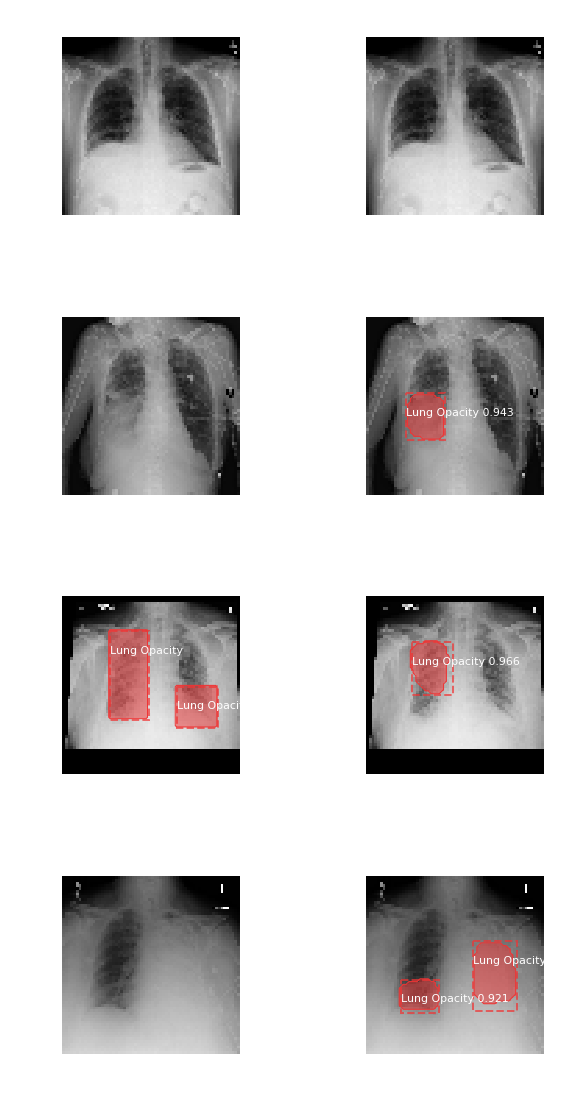

In [48]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
#-

In [71]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

### Final steps - Create the submission file

In [74]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='sample_submission.csv', min_conf=0.95): 
    
    # assume square image
    
    with open(filepath, 'w') as file:
        out_str = "patientId,PredictionString"
        file.write(out_str+"\n")
        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
          
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1) 
            
            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id 
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0: 
                pass
            else: 
                num_instances = len(r['rois'])
                out_str += ","
                for i in range(num_instances): 
                    if r['scores'][i] > min_conf: 
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height 
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1 
                        height = r['rois'][i][2] - y1 
                        bboxes_str = "{} {} {} {}".format(x1, y1, width, height)    
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [75]:
# predict only the first 50 entries
sample_submission_fp = 'sample_submission.csv'
predict(test_image_fps[:1000], filepath=sample_submission_fp)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.79it/s]


In [52]:
output = pd.read_csv(sample_submission_fp, names=['id', 'pred_string'])
output.head(50)
#-

,id,pred_string
0,patientId,PredictionString
1,1c049d3b-394b-47d6-9b54-405d46db1ad7,NaN
2,297d1d92-8116-4bfa-970a-9bddf591f1c2,NaN
3,20705b50-3adb-4e95-bee6-e0fbd8f87776,NaN
4,28a2d8aa-9e29-48d4-b1e3-029e3451ce0b,NaN
5,04bf4408-b797-4f4e-921a-d6305593b060,NaN
6,2902bb15-a15a-4203-8a4b-6dca00a3d9fa,NaN
7,0488a028-fb77-46e1-85fb-f0b86cf57fee,NaN
8,3040d9d7-d895-453f-887c-616c10531960,NaN
9,119a9ba2-0785-4321-b074-dbfcffc5197e,NaN
